In [1]:
import time
import datetime
from collections import OrderedDict
from csv import DictReader
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
###################### BVD recoded model in python ######################################

# Parameters and data

In [3]:
# number of herds in the metapop
nb_herds = 1 # only one in herds.csv
# TIME INFORMATION
delta_t = 7 # time_unit: days
# start_date = "January 1, 2010"
total_duration = 365 #moves.csv only goes to 59 steps (406 days)
nb_steps = int(total_duration/delta_t) # each will mean 7 days

In [4]:
# For vaccination decisions
e_v = 0.95 # vaccine efficacy
decision_periodicity = int(total_duration/5) # adapt according to total duration, so that there are always 5 decision steps
cf_vacc = 50 # fix cost of vaccination (in euros)
cu_vacc = np.mean([4.59, 5.80, 4.33, 5.72]) # mean cost of a BVD vaccine dose (Arnoux, 2021)
r_1 = 800 #cost of a healthy calf (cost )
r_2 = 800*0.01

## Parameters common to all herds

In [5]:


# Dates parameters
K_ext = 0 # constant transmission risk per neighbour herd located outside the metapopulation
day_simulation_start = 1 # day of the year when simulation starts: 1 = 1st Jan, 365 = 31st Dec
pasture_periodicity = 365 # periodicity of the pasture period (days)
day_pasture_start = 60 # day of the year when pasture period starts # March 1st
day_pasture_end = 305 # day of the year when pasture period ends # November 1st

#max distance (m) between herds to take into account between-herd transmission during pasture period
between_herd_contact_radius = 2000 # anyway the geographic_neighbours.csv file only contains links that satify this

#Demography parameters (Life_cycle)
mor_age_threshold = 21 # age before which natural mortality is applied
early_gesta_max =  42 # duration of the early stage of the gestation
mid_gesta_max = 150 # duration between start of gestation and the end of mid_gestation
p_abort_early = 0.8 # probability to abort when infected in early gestation
p_abort_mid =  0.25 # probability to abort when infected in mid gestation
dur_G = 274 # duration of gestation
dur_with_mother = 180 # duration when calves are with their mother in beef herds,
                      # determines duration in YJ and YFbirth
dur_YJ = dur_with_mother
dur_YFbirth = dur_with_mother

#Infection parameters (Health-state)
dur_M = 150 # duration of the protection given by maternal immunity
dur_T = 7 # duration of the transient infection
p_vert_transm =  0.937 # probability of vertical transmission in mid-gestation
p_disease_related_morta =  1-(1-0.5)**(1/365) # probability of disease-related mortality,
                                              # neglecting mortality at birth
p_disease_related_morta =  1 - (1 - p_disease_related_morta)**delta_t    
beta_T_within = 0.03 # transmission rate per transient animal within its group
beta_P_within = 0.5 # transmission rate per persistent animal within its group
beta_P_between =  0.01 # transmission rate per persistent animal to other groups
beta_P_neighbour_pasture = 0.001 # transmission rate per persistent animal located in geographic_neighbours
                                 # and that can access to pasture,
                                 # with a density-dependent transmission
beta_P_neighbour_other = 0 # transmission rate per persistent animal located in geographic_neighbours

#Parameters used in integrate purchase
use_constant_risk_at_purchase = 1 # boolean,
                                    # 1 to use constant probabilities to buy a P animal / a mother of P calf 
                                    # when buying animals from outside the metapopulation,
                                    # 0 to use a probability equal to the prevalence of P / mothers of P calves 
                                    # in the metapopulation (according to the group the animal belongs to,
                                    # i.e. Beef/Dairy x ±lifecycle)
constant_purchase_risk_P_bred_Dairy = 0 # probability (assumed constant) to purchase a P G/NG Dairy animal
                                            # from outside the metapopulation
constant_purchase_risk_P_YJ_Dairy =  0 # probability (assumed constant) to purchase a P YJ Dairy animal 
                                            # from outside the metapopulation
constant_purchase_risk_P_OJ_Dairy =  0 # probability (assumed constant) to purchase a P OJ Dairy animal 
                                            # from outside the metapopulation
constant_purchase_risk_P_YFbirth_Dairy = 0 # probability (assumed constant) to purchase a P YFbirth Dairy
                                              # animal from outside the metapopulation
constant_purchase_risk_P_OFbirth_Dairy = 0 # probability (assumed constant) to purchase a P OFbirth Dairy
                                              # animal from outside the metapopulation
constant_purchase_risk_P_Fadult_Dairy = 0 # probability (assumed constant) to purchase a P Fadult Dairy 
                                                # animal from outside the metapopulation
constant_purchase_risk_P_bred_Beef = 0 # probability (assumed constant) to purchase a P G/NG Beef animal 
                                             # from outside the metapopulation
constant_purchase_risk_P_YJ_Beef = 0 # probability (assumed constant) to purchase a P YJ Beef animal
                                        # from outside the metapopulation
constant_purchase_risk_P_OJ_Beef = 0 # probability (assumed constant) to purchase a P OJ Beef animal
                                        # from outside the metapopulation
constant_purchase_risk_P_YFbirth_Beef = 0  # probability (assumed constant) to purchase a P YFbirth Beef animal
                                        # from outside the metapopulation
constant_purchase_risk_P_OFbirth_Beef = 0  # probability (assumed constant) to purchase a P OFbirth Beef animal
                                        # from outside the metapopulation
constant_purchase_risk_P_Fadult_Beef = 0  # probability (assumed constant) to purchase a P Fadult Beef animal
                                        # from outside the metapopulation
constant_purchase_risk_mother_P_calf_Dairy = 0 # probability (assumed constant) to purchase a gestating
                                                  # Dairy female which will produce a P calf,
                                                  # when buying from outside the metapopulation
constant_purchase_risk_mother_P_calf_Beef = 0 # probability (assumed constant) to purchase a gestating Beef 
                                                    # female which will produce a P calf,
                                                    # when buying from outside the metapopulation
constant_purchase_proba_R_bred_Dairy = 0 # probability (assumed constant) to purchase a R G/NG Dairy animal 
                                         # from outside the metapopulation
constant_purchase_proba_R_YJ_Dairy = 0 # probability (assumed constant) to purchase a R YJ Dairy animal 
                                        # from outside the metapopulation
constant_purchase_proba_R_OJ_Dairy = 0 # probability (assumed constant) to purchase a R OJ Dairy animal 
                                    # from outside the metapopulation
constant_purchase_proba_R_YFbirth_Dairy = 0 # probability (assumed constant) to purchase a R YFbirth Dairy animal 
                                        # from outside the metapopulation 
constant_purchase_proba_R_OFbirth_Dairy = 0 # probability (assumed constant) to purchase a R OFbirth Dairy animal 
                                    # from outside the metapopulation 
constant_purchase_proba_R_Fadult_Dairy = 0 # probability (assumed constant) to purchase a R Fadult Dairy animal 
                                        # from outside the metapopulation
constant_purchase_proba_R_bred_Beef = 0 # probability (assumed constant) to purchase a R G/NG Dairy animal 
                                        # from outside the metapopulation
constant_purchase_proba_R_YJ_Beef = 0 # probability (assumed constant) to purchase a R YJ Beef animal 
                                        # from outside the metapopulation
constant_purchase_proba_R_OJ_Beef = 0 # probability (assumed constant) to purchase a R OJ Beef animal 
                                        # from outside the metapopulation
constant_purchase_proba_R_YFbirth_Beef = 0 # probability (assumed constant) to purchase a R YFbirth Beef animal 
                                        # from outside the metapopulation
constant_purchase_proba_R_OFbirth_Beef = 0 # probability (assumed constant) to purchase a R OFbirth Beef animal 
                                        # from outside the metapopulation
constant_purchase_proba_R_Fadult_Beef = 0 # probability (assumed constant) to purchase a R Fadult Beef animal 
                                        # from outside the metapopulation
    
# 1: consider that the metapopulation is defined by all herds listed in herds.csv,
# even if some of them are not simulated;
# 0: consider that the metapopulation is composed of herds that are actually simulated
use_data_based_metapop = 1

## Read data in the right format, create arrays, and dictionaries:

### Read herd_params.csv as the herd_params dict

 herd_params dict contains herd-dependent parameters

In [6]:
# read a CSV data file for herd params:

# columns: ['population_id', 'step', 'sex_ratio', 'p_female_kept_for_breeding_D',
#       'p_female_kept_for_breeding_B', 'dairy_dur_J', 'dairy_dur_NG',
#       'beef_dur_J', 'beef_dur_NG', 'p_cull_P0_D', 'p_cull_P1_D',
#       'p_cull_P2_D', 'p_cull_P3_D', 'p_cull_P4_D', 'p_cull_P5_D',
#       'p_cull_P0_B', 'p_cull_P1_B', 'p_cull_P2_B', 'p_cull_P3_B',
#       'p_cull_P4_B', 'p_cull_P5_B', 'dairy_Male_dur_Fbirth',
#       'dairy_Female_dur_Fbirth', 'beef_Male_dur_Fbirth',
#       'beef_Female_dur_Fbirth', 'dairy_dur_Fadult', 'beef_dur_Fadult',
#       'p_mor_D', 'p_mor_B']



herd_params = {} 
with open('infbeef_J/herd_params.csv') as csvfile:
    csvreader = DictReader(csvfile, delimiter=',')
    for row in csvreader:
        population_id = int(float(row['population_id']))
        step = int(float(row['step']))
        sex_ratio = float(row['sex_ratio']) # proportion of females in newborns

        #Breeding params (by breed)

        # proportion of newborn females kept for each breeding group
        p_female_kept_for_breeding_D = float(row['p_female_kept_for_breeding_D'])
        p_female_kept_for_breeding_B = float(row['p_female_kept_for_breeding_B'])

        #Duration in J and NG (by breed)

        # dairy_dur_J: mean duration between birth and first calving - dur_G (which is identical for all breeds),
                        # irrespective of the herd they will be at calving
        # dairy_dur_NG: mean calving to calving interval- dur_G, irrespective of parity and of the herd they will be at
                        # calving
        dairy_dur_J, dairy_dur_NG = int(float(row['dairy_dur_J'])), int(float(row['dairy_dur_NG']))
        # beef_dur_J: mean duration between birth and first calving - dur_G (which is identical for all breeds),
                        # irrespective of the herd they will be at calving
        # beef_dur_NG: mean calving to calving interval, irrespective of parity and of the herd they will be
                        # at calving
        beef_dur_J, beef_dur_NG = int(float(row['beef_dur_J'])), int(float(row['beef_dur_NG']))

        #Culling probabilities for Dairy (by parity)

        # p_cull_P0_D: proportion of females that will not calve again in any herd,
                                    # among a specific population of females.
                                    # These females are in the considered herd in the interval 
                                    # and should calve for the first time in the interval+dur_G.
                                    # We should know in the BDNI (any herd) their second calving date 
                                    # or their exit date. 
                                    # Selling to another herd of the BDNI
                                    # is not considered as an exit here. 
                                    # Females without second calving and sold 
                                    # with no further information in the BDNI
                                    # should not be accounted for.
        # p_cull_P1_D: idem for the second calving in dur_G 
        # p_cull_P2_D: idem for the third calving in dur_G 
        # p_cull_P3_D: idem for the fourth calving in dur_G 
        # p_cull_P4_D: idem for the fifth or more calving in dur_G 
        # p_cull_P5_D: probability of culling/selling parity 5 dairy cows - TODO here because missing in herd_params
        p_cull_P0_D, p_cull_P1_D, p_cull_P2_D,p_cull_P3_D,p_cull_P4_D,p_cull_P5_D =\
        float(row['p_cull_P0_D']), float(row['p_cull_P1_D']),float(row['p_cull_P2_D']),\
        float(row['p_cull_P3_D']),float(row['p_cull_P4_D']), float(row['p_cull_P5_D'])

        #Culling probabilities for Beef (by parity)

        # p_cull_P0_B: probability of culling/selling beef heifers
        # p_cull_P1_B: probability of culling/selling parity 1 beef cows
        # p_cull_P2_B: probability of culling/selling parity 2 beef cows
        # p_cull_P3_B: probability of culling/selling parity 3 beef cows
        # p_cull_P4_B: probability of culling/selling parity 4 beef cows
        # p_cull_P5_B: probability of culling/selling parity 5 beef cows - TODO here because missing in herd_params
        p_cull_P0_B, p_cull_P1_B,p_cull_P2_B,p_cull_P3_B, p_cull_P4_B,p_cull_P5_B =\
        float(row['p_cull_P0_B']), float(row['p_cull_P1_B']),  float(row['p_cull_P2_B']),\
        float(row['p_cull_P3_B']), float(row['p_cull_P4_B']), float(row['p_cull_P5_B'])

        #F_birth duration (by breed, and by sex)

        # dairy_Male_dur_Fbirth: mean duration between birth and exit (irrespective of the cause,
                                    # except selling) for males that have survived beyond mor_age_threshold
        # dairy_Female_dur_Fbirth: mean duration between birth and exit (irrespective of the cause,
                                    # except selling) for males that have survived beyond mor_age_threshold
        # beef_Male_dur_Fbirth: duration in F for beef males
        # beef_Female_dur_Fbirth: duration in F for beef females
        dairy_Male_dur_Fbirth, dairy_Female_dur_Fbirth = int(float(row['dairy_Male_dur_Fbirth'])), int(float(row['dairy_Female_dur_Fbirth']))
        beef_Male_dur_Fbirth, beef_Female_dur_Fbirth = int(float(row['beef_Male_dur_Fbirth'])), int(float(row['beef_Female_dur_Fbirth']))

        #Fadult duration (by breed)

        # dairy_dur_Fadult: mean duration between calving and exit (except selling) for specific females.
                            # These females will not calve again in any herd and should have calved in
                            # the interval. We should know in the BDNI (any herd) their exit date.
                            # Selling to another herd is not considered as an exit here.
        # beef_dur_Fadult: duration in F for beef cows (fattening before culling)
        dairy_dur_Fadult, beef_dur_Fadult = int(float(row['dairy_dur_Fadult'])), int(float(row['beef_dur_Fadult']))

        # Mort proba (by breed)

        # p_mor_D: proportion of dead juveniles before mor_age_threshold in dairy herd (for the whole period)
        # p_mor_B: proportion of dead juveniles before mor_age_threshold in beef herd (for the whole period)
        p_mor_D, p_mor_B = float(row['p_mor_D']), float(row['p_mor_B'])

        # Restructure data 
        breeding_params = (p_female_kept_for_breeding_D, p_female_kept_for_breeding_B)
        durations_J = (dairy_dur_J, beef_dur_J)
        durations_NG = (dairy_dur_NG, beef_dur_NG)
        culling_probas_dairy = (p_cull_P0_D, p_cull_P1_D, p_cull_P2_D,p_cull_P3_D,p_cull_P4_D,p_cull_P5_D)
        culling_probas_beef = (p_cull_P0_B, p_cull_P1_B,p_cull_P2_B,p_cull_P3_B, p_cull_P4_B,p_cull_P5_B)
        F_birth_durations_dairy = (dairy_Male_dur_Fbirth, dairy_Female_dur_Fbirth)
        F_birth_durations_beef = (beef_Male_dur_Fbirth, beef_Female_dur_Fbirth)
        F_adult_durations = (dairy_dur_Fadult, beef_dur_Fadult)
        probas_mort = (p_mor_D, p_mor_B)

        herd_params[population_id, step] = {'sex_ratio' : sex_ratio,
                                       'breeding_params' : breeding_params,
                                       'durations_J' : durations_J,
                                       'durations_NG' : durations_NG,
                                       'culling_probas_dairy' : culling_probas_dairy,
                                       'culling_probas_beef' : culling_probas_beef,
                                       'F_birth_durations_dairy' : F_birth_durations_dairy,
                                       'F_birth_durations_beef' : F_birth_durations_beef,
                                       'F_adult_durations' : F_adult_durations,
                                       'probas_mort' :probas_mort}

###  Read herd_status.csv as the herds_state_vars dict
herds_state_vars dict will contain the herd totals at the current time step

In [7]:
# read a CSV data file for herd state vars:
proto_herds_state_vars = {} 

## Initial herd status
initial_herd_status = pd.read_csv('infbeef_J/herd_status.csv', index_col='population_id')

start_counts_dict = {'run' : 0, 
                      'day_herd_infected' : -1,
                      'nb_geographic_neighbours_ext': 0,
                      'nb_animals_purchased_within_metapop': 0,
                      'nb_animals_purchased_outside_metapop': 0,



                       # nb infected
                       'nb_infected_geographic_neighbours_metapop' : 0,
                       'nb_infected_geographic_neighbours_ext' : 0,
                       'nb_infected_purchase_metapop' : 0,
                       'nb_infected_purchase_ext' : 0,
                       'nb_infected_within_herd' : 0,

                      # cumulate incidence of T by group

                      # cumulate number of T in dairy breeding group
                      'cumul_T_bred_Dairy': 0, 
                      # cumulate number of T in dairy fattening group
                      'cumul_T_fat_Dairy': 0, 
                      # cumulate number of T in beef breeding group
                      'cumul_T_bred_Beef': 0,
                      # cumulate number of T in beef fattening group
                      'cumul_T_fat_Beef': 0,
                      # cumulate number of T animals purchased
                      'nb_T_purchase': 0, 
                      # cumulate number of P animals purchased
                      'nb_P_purchase': 0,
                      # cumulate number of mothers of P calves purchased
                      'nb_mother_Pcalf_purchase': 0, 

                      # P in geographic_neighbours

                       # number of persistent YJ_Dairy animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_YJ_Dairy': 0,
                       # number of persistent OJ_Dairy animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_OJ_Dairy': 0,
                       # number of persistent G_Dairy animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_G_Dairy': 0,
                       # number of persistent NG_Dairy animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_NG_Dairy': 0,
                        # number of persistent YFbirth_Dairy animals in geographic_neighbours,
                            # predicted by the model at the between-herd scale
                      'P_neighbour_YFbirth_Dairy': 0,
                        # number of persistent OFbirth_Dairy animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_OFbirth_Dairy': 0,
                        # number of persistent Fadult_Dairy animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_Fadult_Dairy': 0,
                        # number of persistent YJ_Beef animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_YJ_Beef': 0,
                        # number of persistent OJ_Beef animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_OJ_Beef': 0,
                        # number of persistent G_Beef animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_G_Beef': 0,
                        # number of persistent NG_Beef animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_NG_Beef': 0,
                        # number of persistent YFbirth_Beef animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_YFbirth_Beef': 0,
                        # number of persistent OFbirth_Beef animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_OFbirth_Beef': 0,
                        # number of persistent Fadult_Beef animals in geographic_neighbours,
                        # predicted by the model at the between-herd scale
                      'P_neighbour_Fadult_Beef': 0,
                       # total number of persistent animals in
                        # geographic_neighbours (whatever their location, breed
                        # and age), predicted by the model at the between-herd scale
                      'P_neighbour_total': 0, 


                       'step': 0, 
                       'Male': 0, 'Female': 0,
                       'P0' : 0, 'P1' :0, 'P2' : 0, 'P3' : 0, 'P4' : 0, 'P5' : 0,
                       'Dairy':0, 'Beef': 0, 
                       'M': 0, 'S': 0, 'T': 0, 'R': 0, 'P': 0, 'Exit_P': 0, 
                       'YJ': 0, 'OJ': 0, 'G': 0,  'NG': 0,
                       'YFbirth': 0, 'OFbirth': 0, 'Fadult': 0, 
                       'Exit': 0,
                       'total_herd': 0,

                        # Counts for cost function
                           'cum_P': 0, 
                           'cum_G': 0,   
                           'cum_A': 0, 
                           'cum_T': 0, 

                       # serology of lactating females: R_NG_Dairy + 2/3 R_G_Dairy
                       'total_R_NG_Dairy' : 0, 
                       'total_R_G_Dairy' : 0,
                       'total_R_NG_Beef' :  0,
                       'total_R_G_Beef':  0,
                       'total_G_Dairy' :  0,
                       'total_NG_Dairy' :  0,
                       'total_G_Beef' :  0,
                       'total_NG_Beef' :  0,

                       # nb of P/T individuals in breeding/fattening groups in Beef/Dairy
                       'nb_P_bred_Dairy': 0,
                       'nb_P_fat_Dairy': 0,
                       'nb_P_bred_Beef': 0,
                       'nb_P_fat_Beef': 0,
                       'nb_T_bred_Dairy': 0,
                       'nb_T_fat_Dairy' : 0,
                       'nb_T_bred_Beef' : 0,
                       'nb_T_fat_Beef': 0,
                       'nb_T_J_Dairy': 0,
                       'nb_T_Fbirth_Dairy': 0,
                       'nb_T_J_Beef' : 0,
                       'nb_T_Fbirth_Beef': 0,
                       'nb_bred_Dairy': 0,
                       'nb_fat_Dairy': 0,
                       'nb_bred_Beef': 0,
                       'nb_fat_Beef': 0,

                       #For metapop
                       'total_P_other_Dairy' : 0,
                       'total_R_bred_Dairy' : 0,
                       'total_bred_Dairy': 0,
                       'total_P_other_Beef' : 0,
                       'total_R_bred_Beef': 0,
                       'total_bred_Beef': 0,
                     
                       'total_P_YJ_Dairy': 0,
                       'total_P_OJ_Dairy': 0,
                       'total_P_G_Dairy' : 0,
                       'total_P_NG_Dairy': 0,
                       'total_P_YFbirth_Dairy': 0,
                       'total_P_OFbirth_Dairy': 0,
                       'total_P_Fadult_Dairy' : 0,
                       'total_R_YJ_Dairy':  0,
                       'total_R_OJ_Dairy':  0,
                       'total_R_G_Dairy' :  0,
                       'total_R_NG_Dairy':  0,
                       'total_R_YFbirth_Dairy':  0,
                       'total_R_OFbirth_Dairy':  0,
                       'total_R_Fadult_Dairy' :  0,
                       'total_P_YJ_Beef':  0,
                       'total_P_OJ_Beef':  0,
                       'total_P_G_Beef':  0,
                       'total_P_NG_Beef' :  0,
                       'total_P_YFbirth_Beef' :  0,
                       'total_P_OFbirth_Beef' :  0,
                       'total_P_Fadult_Beef' :  0,
                       'total_R_YJ_Beef':  0,
                       'total_R_OJ_Beef':  0,
                       'total_R_G_Beef':  0,
                       'total_R_NG_Beef' :  0,
                       'total_R_YFbirth_Beef' :  0,
                       'total_R_OFbirth_Beef' :  0,
                       'total_R_Fadult_Beef' :  0,
                       'total_YJ_Dairy':  0,
                       'total_OJ_Dairy':  0,
                       'total_G_Dairy' :  0,
                       'total_NG_Dairy' :  0,
                       'total_YFbirth_Dairy':  0,
                       'total_OFbirth_Dairy':  0,
                       'total_Fadult_Dairy':  0,
                       'total_YJ_Beef':  0,
                       'total_OJ_Beef':  0,
                       'total_G_Beef' :  0,
                       'total_NG_Beef' :  0,
                       'total_YFbirth_Beef':  0,
                       'total_OFbirth_Beef':  0,
                       'total_Fadult_Beef':  0,

                       #For infection
                       'T_bred_D': 0,
                       'P_bred_D': 0,
                       'N_bred_D': 0,
                       'T_juv_D' : 0,
                       'P_juv_D' : 0,
                       'N_juv_D' : 0,
                       'T_bred_B': 0,
                       'P_bred_B': 0,
                       'N_bred_B': 0,
                       'T_juv_B' : 0,
                       'P_juv_B' : 0,
                       'N_juv_B' : 0,
                       'T_fat' : 0,
                       'P_fat' : 0,
                       'N_fat' : 0,
                       'P_neighbour_pasture' : 0,
                       'nb_Mother_of_Pcalf_Dairy': 0,
                       'nb_Mother_of_Pcalf_Beef': 0
                     }

#default_herd

with open('infbeef_J/herds.csv') as csvfile:
    csvreader = DictReader(csvfile, delimiter=',')
    for row in itertools.islice(csvreader, nb_herds):
        population_id = int(row['population_id'])
        
        
        proto_herds_state_vars[population_id] ={}
        
        #Initialize other counts
        proto_herds_state_vars[population_id].update(start_counts_dict)
        
        #Read initial herd status is there is any
        if population_id in initial_herd_status.index:
            proto_herds_state_vars[population_id].update(initial_herd_status.T.to_dict()[population_id])

        
herds_state_vars = proto_herds_state_vars.copy()

### Read herds.csv as populations dict

populations dict will contain each animal present at the current step from each herd

In [8]:
# Create a dictionary for animals proto_populations: initially empty since no animals:
proto_populations = {}
with open('infbeef_J/herds.csv') as csvfile:
    csvreader = DictReader(csvfile, delimiter=',')
    for row in itertools.islice(csvreader, nb_herds):
        population_id = int(row['population_id'])
        proto_populations[population_id]= [] 
#print(proto_populations)
populations = proto_populations.copy()

### Read moves.csv as the moves dict

moves dict contains all the movements given by the BDNI

In [9]:
#columns:  # step, source, destination, age, breed, sex, parity, step_next_calving, age_death
        # step: when movement occurs
        # source: ID of source herd (seller)
        # destination: ID of destination herd (buyer)
        # age: age in days
        # breed: Dairy / Beef
        # sex: Male / Female
        # parity: P0 to P5
        # step_next_calving: step when next calving occurs if relevant, otherwise empty (None)
        # age_death: age at death (if known in BDNI)

moves = {}        
with open('infbeef_J/moves.csv') as csvfile:
    # read the CSV file
    csvreader = DictReader(csvfile, delimiter=',')
    for row in csvreader:
        step = int(row['step'])
        src_id, dest_id, age = int(row['source']), int(row['destination']), int(row['age'])
        breed, sex, parity, life_cycle = row['breed'], row['sex'], row['parity'], row['life_cycle']
        if parity == '':
            parity = None
        tmp_se = row['step_exit']
        step_exit = None if tmp_se == '' else int(tmp_se)
        
        # Restructure data as follows:
                # {step: {source: [(dest, states, vars), ...],
                #         ...},
                #  ...}
                # where states = (breed, sex, parity) : states to search in animal list
                # and vars = (age, step_next_calving, age_death) which have to be
                # assigned to animals when entering dest herd
                # group information by step and source herd
                
        if step not in moves:
            moves[step] = {}
        if src_id not in moves[step]:
            moves[step][src_id] = []
        t_states = (breed,sex,parity if parity is not None else None, life_cycle)
        t_vars = (age, step_exit)
        moves[step][src_id].append((dest_id, t_states, t_vars))
#print(moves)

### Read geographic_neighbours.csv as the geographic_neighbours dict


In [10]:
# read a CSV data file for geographic_neighbours: 

#Input Neigh data
pd_geographic_neighbours = pd.read_csv('infbeef_J/neighbours.csv')

#filter pd_geographic_neighbours
pd_geographic_neighbours = pd_geographic_neighbours[pd_geographic_neighbours['distance_m'] <= between_herd_contact_radius] # only ratio of 3 km

#pd geographic_neighbours to dict
geographic_neighbours = (pd_geographic_neighbours.groupby('holding_id')#holding_id
       .apply(lambda x: dict(zip(x['holding_id_nghbrs'],x['distance_m'])))
       .to_dict())

for herd in populations.keys():
    if herd not in geographic_neighbours.keys():
        geographic_neighbours[herd] = []
    else:
        geographic_neighbours[herd] = geographic_neighbours[herd]

In [11]:
#Only id of neighbours for vaccination dynamics
pd_geographic_neighbours = pd.read_csv('infbeef_J/neighbours.csv')
pd_geographic_neighbours = pd_geographic_neighbours[pd_geographic_neighbours['distance_m'] <= between_herd_contact_radius] # only ratio of 3 km

pd_geographic_neighbours = pd_geographic_neighbours.drop(columns=['distance_m'])
pd_geographic_neighbours = pd_geographic_neighbours.set_index('holding_id')

geographic_neighbours_onlyid = pd_geographic_neighbours['holding_id_nghbrs'].groupby(level=0).agg(list).to_dict()

for herd in populations.keys():
    if herd not in geographic_neighbours_onlyid.keys():
        geographic_neighbours_onlyid[herd] = []
    else:
        geographic_neighbours_onlyid[herd] = geographic_neighbours_onlyid[herd]

### Read geographic_neighbours_ext.csv as the geographic_neighbours_ext dict

In [12]:
# read a CSV data file for geographic_neighbours_ext (empty): 

#Input Neigh data
pd_geographic_neighbours_ext = pd.read_csv('infbeef_J/neighbours.csv')

#filter pd_geographic_neighbours_ext
pd_geographic_neighbours_ext = pd_geographic_neighbours_ext[pd_geographic_neighbours_ext['distance_m'] <= between_herd_contact_radius] # only ratio of 3 km

#pd geographic_neighbours_ext to dict
geographic_neighbours_ext = (pd_geographic_neighbours_ext.groupby('holding_id')#holding_id
       .apply(lambda x: dict(zip(x['holding_id_nghbrs'],x['distance_m'])))
       .to_dict())

for herd in populations.keys():
    if herd not in geographic_neighbours_ext.keys():
        geographic_neighbours_ext[herd] = []
    else:
        geographic_neighbours_ext[herd] = geographic_neighbours_ext[herd]

### Initialize inbox dictionary 

Will contain trade messages

In [13]:
proto_in_box = {}
with open('infbeef_J/herds.csv') as csvfile:
    csvreader = DictReader(csvfile, delimiter=',')
    for row in csvreader:
        population_id = int(row['population_id'])
        proto_in_box[population_id]=[]
#print(proto_in_box)
in_box = proto_in_box.copy()

# Functions definition

## Useful functions

In [14]:
# For divisions by 0
def weird_division(n, d):
    return n / d if d else 0

In [15]:
# Useful function for determining if step is in pasture_period
def is_pasture_period(step):
    # Pasture period boolean
    time = step*delta_t
    # Boolean, 1 if current time after beginning of pasture_period, 0 otherwise
    after_pasture_start = ((time - day_simulation_start) % pasture_periodicity) >= day_pasture_start
    # 'Boolean, 1 if current time before end of pasture_period, 0 otherwise'
    before_pasture_end = ((time - day_simulation_start) % pasture_periodicity) < day_pasture_end
    # 'Boolean, 1 if current time during pasture period, false otherwise'
    pasture_period = all([after_pasture_start, before_pasture_end]) if day_pasture_start <= day_pasture_end \
                    else any([after_pasture_start, before_pasture_end])
    return pasture_period 

## Integrate Purchase: potential pb with G and R

In [16]:
def integrate_purchase(step, population_id, delta_t):
    
    """Actually integrate animals purchased by current herd (at previous
    time step) to their destination group in the herd.
    TODO: split into sub-functions
    """
    #print('Integrating purchases from previous step=', step-1)
    to_add = []
    initial_prototypes = OrderedDict() # special dict by category for animals to create at t=0
    step = step - 1 # specification from previous step
    for message in in_box[population_id]:
        #print('Received:', message)
        message_read = message[0] 
        if 'trade' in message_read:
            for t_move in message_read['trade']:
                #print(t_move)
                animal, t_states, t_vars = t_move
                breed, sex, parity, life_cycle = t_states
                age, step_exit = t_vars
                birth_date = step - int(np.round(age / delta_t))
                
                prototype = prototype_default_animal.copy() # copy predefined prototype
                
                ###############################################
                prototype['breed'] = breed 
                prototype['sex'] = sex
                if parity is not None:
                    prototype['parity'] = parity
                else:
                    prototype['parity'] = 'P0'
                    #print('Setting parity to default =>', prototype['parity'])
                # by default do not modify life_cycle nor _time_to_exit_life_cycle 
                # nor birth_date for existing animals
                # (and of course do not modify health_state)
                ###############################################
                
                # if no individual given, create one
                if animal is None:
                    
                    ############################################
                    
                    # for newly created animals, force birth_date, life_cycle and _time_to_exit_life_cycle
                    prototype['birth_date'] = birth_date
                    prototype['life_cycle'] = life_cycle
                    prototype['_time_to_exit_life_cycle'] = step_exit
                    ##################################################################
                    
                    if step == -1:
                        ## CREATION OF INITIAL ANIMALS IN HERDS
                        # animals are not created right now, instead their prototypes are stored by
                        # category (lifecycle, breed) and the health states are computed later on
                        # whole groups
                        # prototype's health state set to S by default
                        #print('creating initial animal {}'.format(prototype))
                        prototype['health_state'] = 'S'
                        prototype['_time_to_exit_health_state'] = None
                        prototype['purchased_ext'] = 0
                        key = (life_cycle, breed)
                        if key not in initial_prototypes:
                            initial_prototypes[key] = []
                        initial_prototypes[key].append(prototype)
                    else:
                        ## CREATION OF A NEW ANIMAL THAT COULD NOT BE PURCHASED

                        ## 1. Because not found in the specified category among animals
                        ##    of a simulated herd of the metapopulation
                        ## 2. Because coming from a herd clearly outside the metapopulation
                        ##    (not in herds.csv)
                        ## 3. Because coming from a herd that could belong to the metapopulation
                        ##    (in herds.csv) or not, depending on parameter use_data_based_metapop

                        ## get ID of source herd and test if the movement is considered
                        ## coming from outside the metapopulation
                        src_id = message[0]['from']
                        if src_id in populations:
                            ## Case 1, buy outside
                            buy_outside_metapopulation = True
                            ######################################
                        elif src_id not in populations:
                            ######################################
                            ## Case 2, buy outside
                            buy_outside_metapopulation = True
                        else:
                            ## Case 3, use parameter
                            buy_outside_metapopulation = not use_data_based_metapop

                        ## WARNING: at this stage, no distinction between animals created
                        ## because they are purchased in herds outside the metapopulation
                        ## and animals created because in the source herd (within the
                        ## metapopulation) their category was not present
    
                        prototype['purchased_ext'] = int(buy_outside_metapopulation)

                        group = 'bred' if life_cycle in ['G', 'NG'] else life_cycle
                        if not buy_outside_metapopulation:
                            ## skip determination of health state, assuming that the metapopulation
                            ## is disease-free -> create S animal considered purchased within metapop
                            herds_state_vars[population_id]['nb_animals_purchased_within_metapop'] += 1
                        else:
                            # determine the risk of being R/P/mother of P
                            if use_constant_risk_at_purchase:
                                ## assume constant risk in the considered group
                                proba_P = eval('constant_purchase_risk_P_{}_{}'.format(group, breed))
                                proba_R = eval('constant_purchase_proba_R_{}_{}'.format(group, breed))
                            else:
                                # choose between 'P', 'R' and 'S' according to the prevalence at metapop scale in animal category (breed x Â±lifecycle)
                                total_group = metapop_state_vars['total_{}_{}'.format(group, breed)]
                                P_in_group =  metapop_state_vars['total_P_{}_{}'.format(group, breed)]
                                R_in_group =  metapop_state_vars['total_R_{}_{}'.format(group, breed)]
                                proba_P = 0 if total_group == 0 else P_in_group / total_group
                                proba_R = 0 if total_group == 0 else R_in_group / total_group

                            #if type(proba_R) == str or type(proba_P) == str:
                            #    print(proba_P, proba_R)
                            health_state = np.random.choice(['P', 'R', 'S'],
                                                            p=[proba_P, proba_R, 1 - proba_R - proba_P])
                            # print(group, breed, P_in_group, "/",
                            # total_group, '=', proba_P, "=>", health_state)
                            prototype['health_state'] = health_state
                            prototype['_time_to_exit_health_state'] = None 
                            
                            if health_state == 'P':
                                #print('Herd {} importing P animal from {}!'.format(int(population_id), src_id))
                                prototype['infected_purchase_ext'] = 1
                                if herds_state_vars[population_id]['day_herd_infected'] < 0:
                                    time = step*delta_t
                                    herds_state_vars[population_id]['day_herd_infected'] = max(0, time)
 
                            ## test if animal can be the mother of a P calf (only if gestating)
                            if life_cycle == 'G' and health_state == 'R':
                                if use_constant_risk_at_purchase:
                                    ## assume constant risk in the considered group
                                    proba_mother_Pcalf = eval('constant_purchase_risk_mother_P_calf_{}'.format(breed))
                                else:
                                    total_group = metapop_state_vars['total_G_{}'.format(breed)]
                                    mother_Pcalf_in_group =  metapop_state_vars['total_mother_Pcalf_{}'.format(breed)]
                                    proba_mother_Pcalf = 0 if total_group == 0 else mother_Pcalf_in_group / total_group
                                is_mother_Pcalf = np.random.binomial(1, proba_mother_Pcalf)
                                # print(breed, mother_Pcalf_in_group, '/', total_group, '=', proba_mother_Pcalf, '=>', is_mother_Pcalf)
                                if  is_mother_Pcalf > 0:
                                    tmp = []
                                    tmp.append(('health_state_calf', 'P'))
                                    tmp.append(('is_mother_of_Pcalf', 1))
                                    for br in ['Beef', 'Dairy']:
                                        tmp.append(('is_mother_of_Pcalf_{}'.format(br), int(breed == br)))
                                    #####################################
                                    prototype.update({tmp})
                                    #####################################
                                    prototype['infected_purchase_ext'] = 1
                                    if herds_state_vars[population_id]['day_herd_infected'] < 0:
                                        time = step*delta_t
                                        herds_state_vars[population_id]['day_herd_infected'] = max(0, time)
                                    # print('Herd {} importing mother of P calf from {}!'.format(int(population_id), src_id))
                            herds_state_vars[population_id]['nb_animals_purchased_outside_metapop'] += 1
                        
                        ################################
                        # Now create animal
                        animal = prototype.copy() 
                        ######################################################################
                        
                else:
                    
                    herds_state_vars[population_id]['nb_animals_purchased_within_metapop'] += 1
                    # animal already exists (i.e. comes from a herd of the metapopulation)
                    animal['purchased_ext'] = 0
                    if animal['health_state'] in ['P', 'T'] or animal['is_mother_of_Pcalf'] == 1:
                        animal['infected_purchase_metapop'] = 1
                        if herds_state_vars[population_id]['day_herd_infected'] < 0:
                            time = step*delta_t
                            herds_state_vars[population_id]['day_herd_infected'] = max(0, time)
                    
                    
                    # for existing animals in OJ/NG life cycle, force _time_to_exit_life_cycle to be consistent with reproduction age in dest herd - does not apply for YJ (?)
                    
                    ########################################
                    if life_cycle in ['NG', 'OJ']:
                        prototype.append(('_time_to_exit_life_cycle', step_exit))
                    animal = prototype.copy() 
                    ########################################

                if animal is not None:
                    to_add.append(animal)

    ## HANDLE INITIAL ANIMALS ACCORDING TO SPECIFIED PROPORTIONS OF R AND NUMBER OF P
    if step == -1:
        ## set status of initial animals according to initial herd status ('herd_status.csv')
        if population_id not in initial_herd_status.index:
            pass
            #if any(initial_prototypes):
                #print("WARNING, undefined initial epidemiological status for herd {}".format(population_id))
        else:
            herd_status = initial_herd_status.loc[population_id]
            #print(initial_prototypes.keys())
            ## iterate over groups to apply proportions of R animals
            for breed in ['Beef', 'Dairy']:
                for life_group in ['YJ', 'OJ', 'bred', 'YFbirth', 'OFbirth', 'Fadult']:
                    total_group = herd_status['total_{}_{}'.format(life_group, breed)]
                    total_R_group = herd_status['total_R_{}_{}'.format(life_group, breed)]
                    prop_R_in_group = 0 if total_group == 0 else total_R_group / total_group

                    if prop_R_in_group == 0:
                        continue
                    prototypes_in_group = []
                    if life_group == 'bred':
                        for subgroup in ['G', 'NG']:
                            if (subgroup, breed) in initial_prototypes:
                                prototypes_in_group += initial_prototypes[(subgroup, breed)]
                    else:
                        if (life_group, breed) in initial_prototypes:
                            prototypes_in_group = initial_prototypes[(life_group, breed)]
                    # compute nb R and change health state accordingly
                    if not any(prototypes_in_group):
                        #if any(initial_prototypes):
                        #    print("WARNING, empty group ({},{}) to apply {} % of R".format(life_group, breed, 100*prop_R_in_group))
                        continue
                    nb_R_in_group = int(np.round(len(prototypes_in_group) * prop_R_in_group))
                    #print(population_id, nb_R_in_group, "in group", life_group, breed)
                    if nb_R_in_group == 0:
                        continue
                    np.random.shuffle(prototypes_in_group)
                    for prototype in prototypes_in_group[:nb_R_in_group]:
                        prototype['health_state'] = 'R'
                        prototype['_time_to_exit_health_state'] = None 
                        
            ## iterate over groups to apply correct number of P animals
            primary_case_P = False ####################
            for breed in ['Beef', 'Dairy']:
                for life_group in ['YJ', 'OJ', 'YFbirth', 'OFbirth', 'other']:
                    nb_P_in_group = herd_status['total_P_{}_{}'.format(life_group, breed)]
                    if nb_P_in_group == 0:
                        continue
                    prototypes_in_group = []
                    if life_group == 'other':
                        for subgroup in ['G', 'NG', 'Fadult']:
                            if (subgroup, breed) in initial_prototypes:
                                prototypes_in_group += initial_prototypes[(subgroup, breed)]
                    else:
                        if (life_group, breed) in initial_prototypes:
                            prototypes_in_group = initial_prototypes[(life_group, breed)]
                    # compute nb R and change health state accordingly
                    if not any(prototypes_in_group):
                        if any(initial_prototypes):
                            print(population_id)
                            print("WARNING, empty group ({},{}) to initialize with {} P animals".format(life_group, breed, nb_P_in_group))
                        continue
                    np.random.shuffle(prototypes_in_group)
                    for prototype in prototypes_in_group[:nb_P_in_group]:
                        primary_case_P = True #####################?
                        prototype['health_state'] = 'P'
                        prototype['_time_to_exit_health_state'] = None
                        
        # then finally create all animals
        all_initial_prototypes = list(itertools.chain(*initial_prototypes.values()))
        ##print(population_id, all_initial_prototypes)
        
        #######################################
        to_add = [prototype.copy() for prototype in all_initial_prototypes]
        #######################################
        
        
    ##print(herds_state_vars[population_id]['total_herd'], to_add)
    # add all animals to current herd            
    if to_add:
        for animal in to_add:
            populations[population_id].append(animal)

    # and set actions correctly:

    for animal in to_add:
        
        ############################
        animal_health_state = animal['health_state']
        
        animal_life_cycle = animal['life_cycle']
        
        is_Dairy = breed == 'Dairy'
        is_Beef = breed == 'Beef'
        
        is_YJ = life_cycle == 'YJ'
        is_OJ = life_cycle == 'OJ'
        is_G = life_cycle == 'G'
        is_NG = life_cycle == 'NG'
        is_YFbirth = life_cycle == 'YFbirth'
        is_OFbirth = life_cycle == 'OFbirth'
        is_Fadult = life_cycle == 'Fadult'
        
        is_P0 = parity == 'P0'
        is_P1 = parity == 'P1'
        is_P2 = parity == 'P2'
        is_P3 = parity == 'P3'
        is_P4 = parity == 'P4'
        is_P5 = parity == 'P5'
        
        
        if animal_health_state == 'T':  
            # On enter T:
            herds_state_vars[population_id]['cumul_T_bred_Dairy'] += is_Dairy * any([is_YJ, is_OJ, is_G, is_NG])
            herds_state_vars[population_id]['cumul_T_fat_Dairy'] += is_Dairy * any([is_YFbirth, is_OFbirth, is_Fadult])
            herds_state_vars[population_id]['cumul_T_bred_Beef'] += is_Beef * any([is_YJ, is_OJ, is_G, is_NG])
            herds_state_vars[population_id]['cumul_T_fat_Beef'] += is_Beef * any([is_YFbirth, is_OFbirth, is_Fadult])
            
        if animal_life_cycle == 'G':  
        
            # On enter G: set_var: p_culling
            
            p_cull_P0_D, p_cull_P1_D, p_cull_P2_D,\
            p_cull_P3_D,p_cull_P4_D,p_cull_P5_D = herd_params[population_id, step+1]['culling_probas_dairy']
            p_cull_P0_B, p_cull_P1_B, p_cull_P2_B,\
            p_cull_P3_B, p_cull_P4_B,p_cull_P5_B = herd_params[population_id, step+1]['culling_probas_beef']


            p_cull_dairy_by_parity = is_P0 * p_cull_P0_D + is_P1 * p_cull_P1_D +\
                                     is_P2 * p_cull_P2_D + is_P3 * p_cull_P3_D +\
                                     is_P4 * p_cull_P4_D + is_P5 * p_cull_P5_D
            p_cull_beef_by_parity = is_P0 * p_cull_P0_B + is_P1 * p_cull_P1_B +\
                                    is_P2 * p_cull_P2_B + is_P3 * p_cull_P3_B +\
                                    is_P4 * p_cull_P4_B + is_P5 * p_cull_P5_B
            p_cull = p_cull_dairy_by_parity * is_Dairy + p_cull_beef_by_parity * is_Beef
            p_culling = min(1.0, p_cull)
            
            # On enter G: set_var: will_be_culled
            #the decision to cull/sell the cow is taken at the beginning
            # of gestation (instead of just before calving for
            # heifers or after calving for cows), but the culling/sale is
            # performed at calving
            
            will_be_culled = np.random.choice(['yes', 'no'], p = [p_culling, 1 - p_culling])
            
            # Update  specific info directly 
            animal['will_be_culled'] = will_be_culled
            
            # On enter G: define the health state of the future calf at the beginning of gestation: 
            # P for P mothers, S for S mothers, in all other cases the calf will be M
            
            if animal_health_state == 'P': # proto_mother_P_calf
                health_state_calf = 'P'
                is_mother_of_Pcalf = 1
                is_mother_of_Pcalf_Dairy= any([is_YJ, is_OJ, is_G, is_NG])* is_Dairy
                is_mother_of_Pcalf_Beef= any([is_YJ, is_OJ, is_G, is_NG])* is_Beef
            elif animal_health_state == 'S': # proto_mother_S_calf
                health_state_calf = 'S'
                is_mother_of_Pcalf = 0
                is_mother_of_Pcalf_Beef = 0
                is_mother_of_Pcalf_Dairy = 0
            else:
                health_state_calf = 'M' # proto_mother_M_calf
                is_mother_of_Pcalf = 0
                is_mother_of_Pcalf_Beef = 0
                is_mother_of_Pcalf_Dairy = 0

            # Update  specific info directly 
            animal['health_state_calf'] = health_state_calf 
            animal['is_mother_of_Pcalf'] = is_mother_of_Pcalf 
            animal['is_mother_of_Pcalf_Beef'] = is_mother_of_Pcalf_Beef
            animal['is_mother_of_Pcalf_Dairy'] = is_mother_of_Pcalf_Dairy    
        
        ########################################################################
        

        if animal['health_state'] == 'T' and step > 0:
            herds_state_vars[population_id]['nb_T_purchase'] += 1
        if animal['health_state'] == 'P' and step > 0: 
            herds_state_vars[population_id]['nb_P_purchase'] += 1
        if animal['is_mother_of_Pcalf'] and step > 0: 
            herds_state_vars[population_id]['nb_mother_Pcalf_purchase'] += 1
           
        ###################################
        ##print(herds_state_vars[population_id]['total_herd'])
        ###################################


    #Clean in_box
    in_box[population_id] = [] 

## Update geographic_neighbours risk

In [17]:
def update_geographic_neighbours_risk(step, population_id, populations, geographic_neighbours):
    """Update the number of P animals in neighbour herds. NOTE: Outside
    pasture period, all values are set to 0.

    """
    ## P_neighbour_total for force_of_infection_neighbour_other_risk
    herds_state_vars[population_id]['P_neighbour_total'] = 0
    for herd_id in geographic_neighbours[population_id]:
        if herd_id in populations:
            herds_state_vars[population_id]['P_neighbour_total'] += herds_state_vars[herd_id]['P']
            
    # force of infection on pasture
    for breed in ['Dairy', 'Beef']:
        for life_cycle in ['YJ', 'OJ', 'G', 'NG', 'YFbirth', 'OFbirth', 'Fadult']:
            statevar_name = 'P_neighbour_{}_{}'.format(life_cycle, breed)
            herds_state_vars[population_id][statevar_name] = 0
            # update only if current herd in pasture period
            if is_pasture_period(step):
                for herd_id in geographic_neighbours[population_id]:
                    # take into accounts geographic_neighbours simulated within the metapop
                    # WARNING: uncomment second part of test if herd-dependent pasture periods
                    if herd_id in populations: # and populations[herd_id].get_model_value('pasture_period'):
                        herds_state_vars[population_id][statevar_name] += herds_state_vars[herd_id]['total_P_{}_{}'.format(life_cycle, breed)]


## Groupings gender, parity, breed

In [18]:
def groupings_gender_parity_breed(populations, population_id, step):
    
    t = populations[population_id]
    
    if t: # if not empty pop
           
        t_df = pd.DataFrame(t)

        # TOTALS for main outputs
        
        # sex counts
        Male, Female = sum(t_df['sex'] == 'Male'), sum(t_df['sex'] == 'Female')
        
        # parity counts
        P0, P1, P2, P3, P4, P5 = sum(t_df['parity'] == 'P0'), sum(t_df['parity'] == 'P1'),\
                                    sum(t_df['parity'] == 'P2'), sum(t_df['parity'] == 'P3'),\
                                    sum(t_df['parity'] == 'P4'), sum(t_df['parity'] == 'P5')
        
        # breed counts
        Beef, Dairy = sum(t_df['breed'] == 'Beef'), sum(t_df['breed'] == 'Dairy')
        
        
        herds_state_vars[population_id].update({#For historic data 
                                           'step': step, 
                                           'Male': Male, 'Female': Female,
                                           'P0' : P0, 'P1' : P1, 'P2' : P2, 'P3' : P3, 'P4' : P4, 'P5' : P5,
                                           'Dairy': Dairy, 'Beef': Beef
                                           })
    

## Groupings for empty herds

In [19]:
def grouping_empty_herd(populations, population_id, step):
    
    t = populations[population_id]
    
    if not t: # if not empty pop
        
        herds_state_vars[population_id].update(start_counts_dict)
        herds_state_vars[population_id].update({'step': step})

## Determine time to exit a state

In [20]:
# Useful function to determine  _time_to_exit_state (life_cycle or health_state)
def determine_time_to_exit_state(state, breed, sex, delta_t, step, population_id):
    
    ## Is Sex, Breed
    is_Male = sex == 'Male'
    is_Female = abs(is_Male - 1)
    
    is_Dairy = breed == 'Dairy'
    is_Beef = breed == 'Beef'
    
    # If Life_cycle
    if state == 'YJ': 
        duration = dur_YJ
    elif state == 'OJ': 
        dairy_dur_J, beef_dur_J = herd_params[population_id, step-1]['durations_J'] 
        dairy_dur_OJ = dairy_dur_J - dur_YJ 
        beef_dur_OJ = beef_dur_J - dur_YJ
        dur_OJ =  is_Dairy * dairy_dur_OJ + is_Beef * beef_dur_OJ
        duration = dur_OJ
    elif state == 'G': 
        duration = dur_G
    elif state == 'NG': 
        dairy_dur_NG, beef_dur_NG = herd_params[population_id, step-1]['durations_NG'] 
        duration = is_Dairy * dairy_dur_NG + is_Beef * beef_dur_NG
        
    elif state == 'YFbirth': 
        duration = dur_YFbirth
    elif state == 'OFbirth': 
        dairy_Male_dur_Fbirth, dairy_Female_dur_Fbirth = herd_params[population_id, step-1]['F_birth_durations_dairy']
        beef_Male_dur_Fbirth, beef_Female_dur_Fbirth = herd_params[population_id, step-1]['F_birth_durations_beef']
        
        dairy_Male_dur_OFbirth = dairy_Male_dur_Fbirth - dur_YFbirth
        dairy_Female_dur_OFbirth = dairy_Female_dur_Fbirth - dur_YFbirth
        beef_Male_dur_OFbirth = beef_Male_dur_Fbirth - dur_YFbirth
        beef_Female_dur_OFbirth = beef_Female_dur_Fbirth - dur_YFbirth
        dur_OFbirth = is_Dairy *\
                      (is_Male * dairy_Male_dur_OFbirth + is_Female * dairy_Female_dur_OFbirth) +\
                      is_Beef * (is_Male * beef_Male_dur_OFbirth + is_Female * beef_Female_dur_OFbirth)
        duration = dur_OFbirth
    elif state == 'Fadult': 
        dairy_dur_Fadult, beef_dur_Fadult = herd_params[population_id, step-1]['F_adult_durations']
        duration = is_Dairy * dairy_dur_Fadult + is_Beef *  beef_dur_Fadult
    # If Health_state
    elif state == 'M':
        duration = dur_M
    elif state == 'T':
        duration = dur_T
    elif state == 'P':
        duration = None
    elif state == 'S':
        duration = None
    elif state == 'R':
        duration = None
    
    # Determine _time_to_exit_state
    if duration == None:
        _time_to_exit_state = None
    else:
        nb_timesteps = int(np.round(duration / delta_t))
        _time_to_exit_state = step + nb_timesteps 
    
    return _time_to_exit_state

## Comment: Infection

In [21]:
def infection(populations, population_id):
    
    # Pasture period
    time = step*delta_t
    # 'Boolean, 1 if current time during pasture period, false otherwise'
    pasture_period = is_pasture_period(step)
    
    for atom in populations[population_id]:
        
        # Infection
        new_health_state, new_time_to_exit_health_state,\
        new_life_cycle, new_time_to_exit_life_cycle = update_health_state(atom, step, population_id, pasture_period)
        
        #if atom['health_state'] != new_health_state:
        #    print(step, atom['health_state'], '->', new_health_state,
        #           atom['_time_to_exit_health_state'] , '->', new_time_to_exit_health_state )
        #    print(atom['life_cycle'], '->', new_life_cycle, 
        #          atom['_time_to_exit_life_cycle'], '->',  new_time_to_exit_life_cycle)

        # Update infection, health state and time to exit:
        atom['health_state'] = new_health_state
        atom['_time_to_exit_health_state'] = new_time_to_exit_health_state
        atom['life_cycle'] = new_life_cycle
        atom['_time_to_exit_life_cycle'] = new_time_to_exit_life_cycle
        
            
    for i in reversed(range(len(populations[population_id]))):
        atom = populations[population_id][i]
        if atom['health_state'] == 'Exit_P':
            #print("Exit_P")
            del populations[population_id][i]
        elif atom['life_cycle'] == 'Exit':
            #print("Exit")
            del populations[population_id][i]
    

In [22]:
# Convert rates to probabilies
def rates_to_probabilities(rate_values, delta_t):
    """Transform the specified list of *rate_values*, interpreted as
    outgoing rates, into probabilities, according to the specified
    time step (*delta_t*) and normalized by *total_rate* (the sum of rates)
    (From Emulsion)
    """
    # compute the exit probability
    total_rate = sum(rate_values)
    base_proba = 1 - np.exp(- total_rate * delta_t)
    # normalize values proportionnally to the rate
    proba_values = [weird_division(base_proba * rate, total_rate) for rate in rate_values]

    # add the probability to stay in the current state
    proba_values.append(1 - base_proba)
    
    return proba_values


### Update health state 

In [23]:
def update_health_state(atom, step, population_id, pasture_period):
   
    
    """Determine the value of the life_cycle state for an animal
    characterized by the other variables, together with the step
    where the animal is expected to exit this life_cycle
    state. The proper value of the life_cycle depends on provided
    information and on parameters which are herd-dependent.

    """
    
    breed = atom['breed']
    health_state = atom['health_state']
    _time_to_exit_health_state = atom['_time_to_exit_health_state']
    life_cycle = atom['life_cycle']
    _time_to_exit_life_cycle = atom['_time_to_exit_life_cycle']
    ## Is Breed, Life-cycle, etc
    
    is_Dairy = breed == 'Dairy'
    is_Beef = breed == 'Beef'
    
    is_YJ = life_cycle == 'YJ'
    is_OJ = life_cycle == 'OJ'
    is_G = life_cycle == 'G'
    is_NG = life_cycle == 'NG'
    is_YFbirth = life_cycle == 'YFbirth'
    is_OFbirth = life_cycle == 'OFbirth'
    is_Fadult = life_cycle == 'Fadult'
    
    is_bred = any([is_NG, is_G, is_Beef * any([is_YJ, is_YFbirth])])
    is_juv = any([is_OJ, is_Dairy * is_YJ])
    is_fat = any([is_Fadult, is_OFbirth, is_Dairy * is_YFbirth])
    is_on_pasture = is_bred # we choose to neglect the exposure of Fadult possibly on pasture because
                            # they have little chance to have P animals or contribute to transmission
    
    # Read 
    T_bred_D = herds_state_vars[population_id]['T_bred_D']
    P_bred_D = herds_state_vars[population_id]['P_bred_D']
    N_bred_D =  herds_state_vars[population_id]['N_bred_D']
    T_juv_D = herds_state_vars[population_id]['T_juv_D']
    P_juv_D = herds_state_vars[population_id]['P_juv_D']
    N_juv_D = herds_state_vars[population_id]['N_juv_D']
    T_bred_B = herds_state_vars[population_id]['T_bred_B']
    P_bred_B = herds_state_vars[population_id]['P_bred_B']
    N_bred_B = herds_state_vars[population_id]['N_bred_B']
    T_juv_B = herds_state_vars[population_id]['T_juv_B']
    P_juv_B = herds_state_vars[population_id]['P_juv_B']
    N_juv_B = herds_state_vars[population_id]['N_juv_B']
    T_fat = herds_state_vars[population_id]['T_fat']
    P_fat = herds_state_vars[population_id]['P_fat']
    N_fat = herds_state_vars[population_id]['N_fat']
    P_neighbour_pasture = herds_state_vars[population_id]['P_neighbour_pasture']
    P_neighbour_total = herds_state_vars[population_id]['P_neighbour_total']
    
    
    #Compute force of infection
    force_of_infection_dairy_juv = weird_division(is_Dairy * is_juv *
                                                  (beta_T_within * T_juv_D +
                                                   beta_P_within * P_juv_D +
                                                   beta_P_between * (P_bred_D + P_fat + P_bred_B + P_juv_B)),
                                                  N_juv_D)
    force_of_infection_dairy_bred = weird_division(is_Dairy * is_bred *
                                                   (beta_T_within * T_bred_D + beta_P_within * P_bred_D +
                                                    beta_P_between * (P_juv_D + P_fat + P_bred_B + P_juv_B)),
                                                   N_bred_D)
    
    force_of_infection_beef_juv= weird_division(is_Beef * is_juv *
                                                (beta_T_within * T_juv_B + beta_P_within * P_juv_B +
                                                 beta_P_between * (P_bred_D + P_fat + P_bred_B + P_juv_D)),
                                                N_juv_B)
    force_of_infection_beef_bred= weird_division(is_Beef * is_bred * 
                                                 (beta_T_within * T_bred_B + beta_P_within * P_bred_B +
                                                  beta_P_between * (P_bred_D + P_fat + P_juv_B + P_juv_D)),
                                                 N_bred_B)
    
    force_of_infection_fat = weird_division(is_fat *
                                            (beta_T_within * T_fat + beta_P_within * P_fat +
                                             beta_P_between * (P_juv_D + P_juv_B + P_bred_D + P_bred_B)),
                                            N_fat)
    
    force_of_infection_neighbour_on_pasture = pasture_period * is_on_pasture *\
                                              beta_P_neighbour_pasture * P_neighbour_pasture
    
    # expression for the force of infection of all animals due to exposure to all P animals in neighbour herds
    # (in the metapopulation), whatever their location (building or pasture), breed and age
    force_of_infection_neighbour_other_risk = beta_P_neighbour_other * P_neighbour_total
    
    # force of infection experienced by susceptible animals, from infectious individuals already present in the herd
    force_of_infection_within_herd = force_of_infection_dairy_juv + force_of_infection_dairy_bred + \
                                     force_of_infection_fat +  force_of_infection_beef_juv + \
                                     force_of_infection_beef_bred
            
    # force of infection experienced by susceptible animals, from infectious individuals in herds of the metapopulation, located in the neighbourhood
    force_of_infection_geographic_neighbours_metapop = force_of_infection_neighbour_on_pasture + \
                                            force_of_infection_neighbour_other_risk
        
    # force of infection experienced by susceptible animals, assuming a constant external risk due to each neighbour herd outside the metapopulation    
    nb_geographic_neighbours_ext = herds_state_vars[population_id]['nb_geographic_neighbours_ext']
    force_of_infection_geographic_neighbours_ext = K_ext * nb_geographic_neighbours_ext
    
    #Update health state
    
    if health_state == 'M': 
        
        # all animals stay in M for a constant duration defined  in state M
        if step >= _time_to_exit_health_state:
            health_state = 'S' 
            _time_to_exit_health_state = None
            
    elif health_state == 'S':
        
        probas_infection = rates_to_probabilities([force_of_infection_within_herd,
                                                  force_of_infection_geographic_neighbours_metapop,
                                                  force_of_infection_geographic_neighbours_ext], delta_t)
        
        health_state = np.random.choice(['T_within_herd', 'T_geographic_neighbours_metapop',
                                         'T_geographic_neighbours_ext', 'S'], p = probas_infection)
        
        # when infected, the health state of the future calf of
        # gestating females can change. Besides, gestating females can
        # abort - this infections is caused by infectious animals already in the herd
        
        if health_state == 'T_within_herd':
            #print('INFECTED within herd')
            atom['infected_within_herd'] = 1
            health_state = 'T'
        elif health_state == 'T_geographic_neighbours_metapop':
            #print('INFECTED geographic_neighbours metapop')
            atom['infected_geographic_neighbours_metapop'] = 1
            health_state = 'T'
        elif health_state == 'T_geographic_neighbours_ext':
            #print('INFECTED geographic_neighbours ext')
            atom['infected_geographic_neighbours_ext'] = 1
            health_state = 'T'
        
        if health_state == 'T':  
            
            _time_to_exit_health_state = determine_time_to_exit_state(health_state, breed, sex,\
                                                                      delta_t, step, population_id)
            # On enter T:
            herds_state_vars[population_id]['cumul_T_bred_Dairy'] += is_Dairy * any([is_YJ, is_OJ, is_G, is_NG])
            herds_state_vars[population_id]['cumul_T_fat_Dairy'] += is_Dairy * any([is_YFbirth, is_OFbirth, is_Fadult])
            herds_state_vars[population_id]['cumul_T_bred_Beef'] += is_Beef * any([is_YJ, is_OJ, is_G, is_NG])
            herds_state_vars[population_id]['cumul_T_fat_Beef'] += is_Beef * any([is_YFbirth, is_OFbirth, is_Fadult])
            
            #On cross:
            time = step*delta_t
            day_herd_infected = herds_state_vars[population_id]['day_herd_infected']
            day_herd_infected = time if day_herd_infected < 0 else day_herd_infected
            
            # When infected, the health state of the future calf of gestating females can change: 
            
            if is_G :
                
                ###############################
                step_entered = _time_to_exit_life_cycle - (dur_G/delta_t)
                duration_in_life_cycle = int(step - step_entered)*delta_t
                ###############################
                
                is_early_gesta = (duration_in_life_cycle <= early_gesta_max)*1.0
                is_mid_gesta = (early_gesta_max < duration_in_life_cycle) and (duration_in_life_cycle <= mid_gesta_max)
                #print(is_early_gesta, is_mid_gesta, duration_in_life_cycle)
                p_proto_mother_M_calf = is_early_gesta
                vaccination_decision = int(current_decisions[population_id])
                #print('population_id', population_id, 'vaccination_decision', vaccination_decision)
                p_proto_mother_P_calf = is_mid_gesta * p_vert_transm * (1 - (e_v * vaccination_decision))
                #print('proba_P_with_decision', p_vert_transm * (1 - (e_v * vaccination_decision ) ))
                p_proto_mother_R_calf = (1 -  p_proto_mother_M_calf- p_proto_mother_P_calf )

                proto_mother = np.random.choice(['M_calf','P_calf', 'R_calf'],
                                                p = [p_proto_mother_M_calf, p_proto_mother_P_calf,
                                                     p_proto_mother_R_calf ])

                # update calf health state
                if proto_mother == 'M_calf':  # proto_mother_M_calf
                    health_state_calf = 'M'
                    is_mother_of_Pcalf = 0
                    is_mother_of_Pcalf_Beef = 0
                    is_mother_of_Pcalf_Dairy = 0
                elif proto_mother == 'P_calf': # proto_mother_P_calf
                    #print('proto_mother_P_calf')
                    health_state_calf = 'P'
                    is_mother_of_Pcalf = 1
                    is_mother_of_Pcalf_Beef = any([is_YJ, is_OJ, is_G, is_NG]) * is_Beef
                    is_mother_of_Pcalf_Dairy = any([is_YJ, is_OJ, is_G, is_NG]) * is_Dairy
                    herds_state_vars[population_id]['cum_P'] += 1
                elif proto_mother == 'R_calf': # proto_mother_R_calf
                    health_state_calf = 'R'
                    is_mother_of_Pcalf = 0
                    is_mother_of_Pcalf_Beef = 0
                    is_mother_of_Pcalf_Dairy = 0
                    
                # Update calf info directly 
                atom['health_state_calf'] = health_state_calf 
                    
                # Besides, gestating females can abort:
                will_be_culled = atom['will_be_culled']
                
                boolean_will_be_culled = 1 if will_be_culled == 'yes' else 0
                proba_abortion = is_early_gesta * p_abort_early + is_mid_gesta * p_abort_mid
                #proba_abortion = 1- (1-proba_abortion)**delta_t
                p_proto_aborted_NG = proba_abortion * (1-boolean_will_be_culled)
                p_proto_aborted_F = proba_abortion * boolean_will_be_culled
                
                proto_aborted = np.random.choice(['aborted_NG', 'aborted_F', 'not_aborted'],
                                                 p = [p_proto_aborted_NG, p_proto_aborted_F,
                                                      1 - proba_abortion])
                
                if proto_aborted == 'aborted_NG':  
                    #print("aborted")
                    life_cycle = 'NG'
                    _time_to_exit_life_cycle = determine_time_to_exit_state(life_cycle, breed, sex,\
                                                                           delta_t, step, population_id)
                    is_mother_of_Pcalf = 0
                    is_mother_of_Pcalf_Beef = 0
                    is_mother_of_Pcalf_Dairy = 0
                    herds_state_vars[population_id]['cum_A'] += 1
                elif proto_aborted ==  'aborted_F':
                    life_cycle = 'Fadult'
                    #print("aborted")
                    _time_to_exit_life_cycle = determine_time_to_exit_state(life_cycle, breed, sex,\
                                                                           delta_t, step, population_id)
                    is_mother_of_Pcalf = 0
                    is_mother_of_Pcalf_Beef = 0
                    is_mother_of_Pcalf_Dairy = 0
                    herds_state_vars[population_id]['cum_A'] += 1
                    
                atom['is_mother_of_Pcalf'] = is_mother_of_Pcalf 
                atom['is_mother_of_Pcalf_Beef'] = is_mother_of_Pcalf_Beef
                atom['is_mother_of_Pcalf_Dairy'] = is_mother_of_Pcalf_Dairy 
                
            elif is_YJ :    
                herds_state_vars[population_id]['cum_T'] += 1
            elif is_YFbirth :    
                herds_state_vars[population_id]['cum_T'] += 1
                
    elif health_state == 'T':
        if step >= _time_to_exit_health_state: 
            health_state = 'R' 
            _time_to_exit_health_state = None
        
    elif health_state == 'P':
        health_state = np.random.choice(['Exit_P', 'P'], p=[p_disease_related_morta,
                                                          1 - p_disease_related_morta])        
    
    return health_state, _time_to_exit_health_state, life_cycle, _time_to_exit_life_cycle

### infection grouping

In [24]:
def infection_grouping(populations, population_id, step):
    
    t = populations[population_id]
    
    if t: # if not empty pop
           
        t_df = pd.DataFrame(t)

        # TOTALS for main outputs
        
        # health_state counts
        P, Exit_P, M, S, T, R =  sum(t_df['health_state'] == 'P'), sum(t_df['health_state'] == 'Exit_P'),\
                           sum(t_df['health_state'] == 'M'),\
                           sum(t_df['health_state'] == 'S'),\
                           sum(t_df['health_state'] == 'T'),\
                           sum(t_df['health_state'] == 'R')

        # Totals for other outputs

        # Totals by health_state (P,R,T), Life-cycle, Breed 

        total_P_YJ_Dairy = sum( (t_df['health_state'] == 'P') & (t_df['life_cycle'] == 'YJ') & (t_df['breed'] == 'Dairy'))
        total_P_OJ_Dairy = sum( (t_df['health_state'] == 'P') & (t_df['life_cycle'] == 'OJ') & (t_df['breed'] == 'Dairy'))
        total_P_G_Dairy = sum((t_df['health_state'] == 'P') & (t_df['life_cycle'] == 'G') & (t_df['breed'] == 'Dairy'))
        total_P_NG_Dairy = sum((t_df['health_state'] == 'P') & (t_df['life_cycle'] == 'NG') & (t_df['breed'] == 'Dairy'))
        total_P_YFbirth_Dairy = sum((t_df['health_state'] == 'P') & (t_df['life_cycle'] == 'YFbirth') & (t_df['breed'] == 'Dairy'))
        total_P_OFbirth_Dairy = sum((t_df['health_state'] == 'P') & (t_df['life_cycle'] == 'OFbirth') & (t_df['breed'] == 'Dairy'))
        total_P_Fadult_Dairy = sum((t_df['health_state'] == 'P') & (t_df['life_cycle'] == 'Fadult') & (t_df['breed'] == 'Dairy'))
        total_R_YJ_Dairy = sum( (t_df['health_state'] == 'R') & (t_df['life_cycle'] == 'YJ') & (t_df['breed'] == 'Dairy'))
        total_R_OJ_Dairy = sum( (t_df['health_state'] == 'R') & (t_df['life_cycle'] == 'OJ') & (t_df['breed'] == 'Dairy'))
        total_R_G_Dairy = sum((t_df['health_state'] == 'R') & (t_df['life_cycle'] == 'G') & (t_df['breed'] == 'Dairy'))
        total_R_NG_Dairy = sum((t_df['health_state'] == 'R') & (t_df['life_cycle'] == 'NG') & (t_df['breed'] == 'Dairy'))
        total_R_YFbirth_Dairy = sum((t_df['health_state'] == 'R') & (t_df['life_cycle'] == 'YFbirth') & (t_df['breed'] == 'Dairy'))
        total_R_OFbirth_Dairy = sum((t_df['health_state'] == 'R') & (t_df['life_cycle'] == 'OFbirth') & (t_df['breed'] == 'Dairy'))
        total_R_Fadult_Dairy = sum((t_df['health_state'] == 'R') & (t_df['life_cycle'] == 'Fadult') & (t_df['breed'] == 'Dairy'))
        total_T_YJ_Dairy = sum((t_df['health_state'] == 'T') & (t_df['life_cycle'] == 'YJ') & (t_df['breed'] == 'Dairy'))
        total_T_OJ_Dairy = sum((t_df['health_state'] == 'T') & (t_df['life_cycle'] == 'OJ') & (t_df['breed'] == 'Dairy'))
        total_T_G_Dairy = sum((t_df['health_state'] == 'T') & (t_df['life_cycle'] == 'G') & (t_df['breed'] == 'Dairy'))
        total_T_NG_Dairy = sum((t_df['health_state'] == 'T') & (t_df['life_cycle'] == 'NG') & (t_df['breed'] == 'Dairy'))
        total_T_YFbirth_Dairy = sum((t_df['health_state'] == 'T')& (t_df['life_cycle'] == 'YFbirth') & (t_df['breed'] == 'Dairy'))
        total_T_OFbirth_Dairy = sum((t_df['health_state'] == 'T')& (t_df['life_cycle'] == 'OFbirth') & (t_df['breed'] == 'Dairy'))
        total_T_Fadult_Dairy = sum((t_df['health_state'] == 'T') & (t_df['life_cycle'] == 'Fadult') & (t_df['breed'] == 'Dairy'))
        total_P_YJ_Beef = sum((t_df['health_state'] == 'P') & (t_df['life_cycle'] == 'YJ') & (t_df['breed'] == 'Beef'))
        total_P_OJ_Beef = sum((t_df['health_state'] == 'P') & (t_df['life_cycle'] == 'OJ') & (t_df['breed'] == 'Beef'))
        total_P_G_Beef  = sum((t_df['health_state'] == 'P') & (t_df['life_cycle'] == 'G') & (t_df['breed'] == 'Beef'))
        total_P_NG_Beef  = sum((t_df['health_state'] == 'P')& (t_df['life_cycle'] == 'NG') & (t_df['breed'] == 'Beef'))
        total_P_YFbirth_Beef  = sum((t_df['health_state'] == 'P')& (t_df['life_cycle'] == 'YFbirth') & (t_df['breed'] == 'Beef'))
        total_P_OFbirth_Beef  = sum((t_df['health_state'] == 'P')& (t_df['life_cycle'] == 'OFbirth') & (t_df['breed'] == 'Beef'))
        total_P_Fadult_Beef  = sum((t_df['health_state'] == 'P') & (t_df['life_cycle'] == 'Fadult') & (t_df['breed'] == 'Beef'))
        total_R_YJ_Beef = sum((t_df['health_state'] == 'R') & (t_df['life_cycle'] == 'YJ') & (t_df['breed'] == 'Beef'))
        total_R_OJ_Beef = sum((t_df['health_state'] == 'R') & (t_df['life_cycle'] == 'OJ') & (t_df['breed'] == 'Beef'))
        total_R_G_Beef  = sum((t_df['health_state'] == 'R') & (t_df['life_cycle'] == 'G') & (t_df['breed'] == 'Beef'))
        total_R_NG_Beef  = sum((t_df['health_state'] == 'R')& (t_df['life_cycle'] == 'NG') & (t_df['breed'] == 'Beef'))
        total_R_YFbirth_Beef  = sum((t_df['health_state'] == 'R')& (t_df['life_cycle'] == 'YFbirth') & (t_df['breed'] == 'Beef'))
        total_R_OFbirth_Beef  = sum((t_df['health_state'] == 'R')& (t_df['life_cycle'] == 'OFbirth') & (t_df['breed'] == 'Beef'))
        total_R_Fadult_Beef  = sum((t_df['health_state'] == 'R') & (t_df['life_cycle'] == 'Fadult') & (t_df['breed'] == 'Beef'))
        total_T_YJ_Beef = sum((t_df['health_state'] == 'T') & (t_df['life_cycle'] == 'YJ') & (t_df['breed'] == 'Beef'))
        total_T_OJ_Beef = sum((t_df['health_state'] == 'T') & (t_df['life_cycle'] == 'OJ') & (t_df['breed'] == 'Beef'))
        total_T_G_Beef = sum((t_df['health_state'] == 'T')& (t_df['life_cycle'] == 'G') & (t_df['breed'] == 'Beef'))
        total_T_NG_Beef = sum((t_df['health_state'] == 'T') & (t_df['life_cycle'] == 'NG') & (t_df['breed'] == 'Beef'))
        total_T_YFbirth_Beef = sum((t_df['health_state'] == 'T') & (t_df['life_cycle'] == 'YFbirth') & (t_df['breed'] == 'Beef'))
        total_T_OFbirth_Beef = sum((t_df['health_state'] == 'T') & (t_df['life_cycle'] == 'OFbirth') & (t_df['breed'] == 'Beef'))
        total_T_Fadult_Beef = sum((t_df['health_state'] == 'T') & (t_df['life_cycle'] == 'Fadult') & (t_df['breed'] == 'Beef'))

        # nb infected
        nb_infected_geographic_neighbours_metapop = sum(t_df['infected_geographic_neighbours_metapop'] == 1)
        nb_infected_geographic_neighbours_ext = sum(t_df['infected_geographic_neighbours_ext'] == 1) 
        nb_infected_purchase_metapop = sum(t_df['infected_purchase_metapop'] == 1)
        nb_infected_purchase_ext = sum(t_df['infected_purchase_ext'] == 1)
        nb_infected_within_herd = sum(t_df['infected_within_herd'] == 1)
    
        # output parameters (calculated from state variables or parameters)
        # nb of P/T individuals in breeding/fattening groups in Beef/Dairy
        
        # total number of P individuals among dairy breeding group (*J, G, NG)
        nb_P_bred_Dairy = total_P_YJ_Dairy + total_P_OJ_Dairy + total_P_G_Dairy + total_P_NG_Dairy
        # total number of P individuals among dairy fattening group (*Fbirth, Fadult)
        nb_P_fat_Dairy = total_P_YFbirth_Dairy + total_P_OFbirth_Dairy + total_P_Fadult_Dairy
        # total number of P individuals among beef breeding group (*J, G, NG)
        nb_P_bred_Beef = total_P_YJ_Beef + total_P_OJ_Beef + total_P_G_Beef + total_P_NG_Beef
        # total number of P individuals among beef fattening group (Fbirth, Fadult))
        nb_P_fat_Beef = total_P_YFbirth_Beef + total_P_OFbirth_Beef + total_P_Fadult_Beef
        # total number of T individuals among dairy breeding group (J, G, NG))
        nb_T_bred_Dairy = total_T_YJ_Dairy + total_T_OJ_Dairy + total_T_G_Dairy + total_T_NG_Dairy
        # total number of T individuals among dairy fattening group (Fbirth, Fadult)
        nb_T_fat_Dairy = total_T_YFbirth_Dairy + total_T_OFbirth_Dairy + total_T_Fadult_Dairy
        # total number of T individuals among beef breeding group (J, G, NG)
        nb_T_bred_Beef = total_T_YJ_Beef + total_T_OJ_Beef + total_T_G_Beef + total_T_NG_Beef
        # total number of T individuals among beef fattening group (Fbirth, Fadult)
        nb_T_fat_Beef = total_T_YFbirth_Beef + total_T_OFbirth_Beef + total_T_Fadult_Beef
        # total number of T individuals among dairy juveniles (YJ, OJ)
        nb_T_J_Dairy = total_T_YJ_Dairy + total_T_OJ_Dairy
        # total number of T individuals among Fbirth (YFbirth, OFbirth)
        nb_T_Fbirth_Dairy = total_T_YFbirth_Dairy + total_T_OFbirth_Dairy
        # total number of T individuals among beef juveniles (YJ, OJ)
        nb_T_J_Beef = total_T_YJ_Beef + total_T_OJ_Beef
        # total number of T individuals among Fbirth (YFbirth, OFbirth)
        nb_T_Fbirth_Beef = total_T_YFbirth_Beef + total_T_OFbirth_Beef
        
        
        # For update_health_state() 
        
        # number of transient animals in the dairy breeding group
        T_bred_D = total_T_G_Dairy + total_T_NG_Dairy
        # number of persistent animals in the dairy breeding group
        P_bred_D = total_P_G_Dairy + total_P_NG_Dairy
        
        # number of transient animals in the dairy juvenile group (YJ + OJ)
        T_juv_D = total_T_YJ_Dairy + total_T_OJ_Dairy
        # number of persistent animals in the dairy juvenile group (YJ + OJ)
        P_juv_D = total_P_YJ_Dairy + total_P_OJ_Dairy
        
        # number of transient animals in the beef breeding group
        T_bred_B = total_T_YJ_Beef + total_T_YFbirth_Beef + total_T_G_Beef + total_T_NG_Beef
        # number of persistent animals in the beef breeding group
        P_bred_B = total_P_YJ_Beef + total_P_YFbirth_Beef + total_P_G_Beef + total_P_NG_Beef
        
        # number of transient animals in the beef juveniles group (OJ alone!)
        T_juv_B = total_T_OJ_Beef
        # number of persistent animals in the beef juveniles group (OJ alone!)
        P_juv_B = total_P_OJ_Beef
        
        # number of transient animals in the fattening group
        # (dairy YFbirth and OFbirth, all Fadult, beef OFbirth)
        T_fat = total_T_YFbirth_Dairy + total_T_OFbirth_Dairy + total_T_Fadult_Dairy +\
                total_T_Fadult_Beef + total_T_OFbirth_Beef
        # number of persistent animals in the fattening group
        # (dairy YFbirth and OFbirth, all Fadult, beef OFbirth)
        P_fat = total_P_YFbirth_Dairy + total_P_OFbirth_Dairy + total_P_Fadult_Dairy +\
                total_P_Fadult_Beef + total_P_OFbirth_Beef
        

        herds_state_vars[population_id].update({#For historic data 
                                           'step': step, 
                                           'M': M, 'S': S, 'T': T, 'R': R, 'P': P, 'Exit_P': Exit_P, 
            
                                           # Totals by health_state (P,R,T), Life-cycle, Breed (for metapop)
                                           'total_P_YJ_Dairy': total_P_YJ_Dairy,
                                           'total_P_OJ_Dairy': total_P_OJ_Dairy,
                                           'total_P_G_Dairy' : total_P_G_Dairy ,
                                           'total_P_NG_Dairy': total_P_NG_Dairy,
                                           'total_P_YFbirth_Dairy': total_P_YFbirth_Dairy,
                                           'total_P_OFbirth_Dairy': total_P_OFbirth_Dairy,
                                           'total_P_Fadult_Dairy' : total_P_Fadult_Dairy,
            
                                           'total_R_YJ_Dairy': total_R_YJ_Dairy,
                                           'total_R_OJ_Dairy': total_R_OJ_Dairy,
                                           'total_R_G_Dairy' : total_R_G_Dairy ,
                                           'total_R_NG_Dairy': total_R_NG_Dairy,
                                           'total_R_YFbirth_Dairy': total_R_YFbirth_Dairy,
                                           'total_R_OFbirth_Dairy': total_R_OFbirth_Dairy,
                                           'total_R_Fadult_Dairy' : total_R_Fadult_Dairy, 
            
                                           'total_P_YJ_Beef': total_P_YJ_Beef,
                                           'total_P_OJ_Beef': total_P_OJ_Beef,
                                           'total_P_G_Beef' : total_P_G_Beef ,
                                           'total_P_NG_Beef': total_P_NG_Beef,
                                           'total_P_YFbirth_Beef': total_P_YFbirth_Beef,
                                           'total_P_OFbirth_Beef': total_P_OFbirth_Beef,
                                           'total_P_Fadult_Beef' : total_P_Fadult_Beef,
            
                                           'total_R_YJ_Beef': total_R_YJ_Beef,
                                           'total_R_OJ_Beef': total_R_OJ_Beef,
                                           'total_R_G_Beef' : total_R_G_Beef ,
                                           'total_R_NG_Beef': total_R_NG_Beef,
                                           'total_R_YFbirth_Beef': total_R_YFbirth_Beef,
                                           'total_R_OFbirth_Beef': total_R_OFbirth_Beef,
                                           'total_R_Fadult_Beef' : total_R_Fadult_Beef, 
            
                                           # nb of P/T individuals in breeding/fattening groups in Beef/Dairy
                                           # For extra outputs
                                           'nb_P_bred_Dairy': nb_P_bred_Dairy,
                                           'nb_P_fat_Dairy': nb_P_fat_Dairy,
                                           'nb_P_bred_Beef': nb_P_bred_Beef,
                                           'nb_P_fat_Beef': nb_P_fat_Beef,
                                           'nb_T_bred_Dairy': nb_T_bred_Dairy,
                                           'nb_T_fat_Dairy' : nb_T_fat_Dairy,
                                           'nb_T_bred_Beef' : nb_T_bred_Beef,
                                           'nb_T_fat_Beef': nb_T_fat_Beef,
                                           'nb_T_J_Dairy': nb_T_J_Dairy,
                                           'nb_T_Fbirth_Dairy': nb_T_Fbirth_Dairy,
                                           'nb_T_J_Beef' : nb_T_J_Beef,
                                           'nb_T_Fbirth_Beef': nb_T_Fbirth_Beef,
            
                                           # For update_health_state() 
                                           'T_bred_D': T_bred_D,
                                           'P_bred_D': P_bred_D,
                                           'T_juv_D' : T_juv_D,
                                           'P_juv_D' : P_juv_D,
                                           'T_bred_B': T_bred_B,
                                           'P_bred_B': P_bred_B,
                                           'T_juv_B' : T_juv_B,
                                           'P_juv_B' : P_juv_B,
                                           'T_fat' : T_fat,
                                           'P_fat' : P_fat, 
            
                                           # nb infected
                                           'nb_infected_geographic_neighbours_metapop' : nb_infected_geographic_neighbours_metapop,
                                           'nb_infected_geographic_neighbours_ext' : nb_infected_geographic_neighbours_ext,
                                           'nb_infected_purchase_metapop' : nb_infected_purchase_metapop,
                                           'nb_infected_purchase_ext' : nb_infected_purchase_ext,
                                           'nb_infected_within_herd' : nb_infected_within_herd
                                           #day_herd_infected?
                                           
        
                                           #
                                           })
    

## Comment: Demography

In [25]:
def demography(step, populations, population_id):
    
    for atom in populations[population_id]:

        new_life_cycle, new_time_to_exit_life_cycle = update_life_cycle(atom, step, population_id)
        

        #if atom['life_cycle'] != new_life_cycle:
        #    print(step, population_id, atom['life_cycle'], '->', new_life_cycle, 
        #          atom['_time_to_exit_life_cycle'], '->',  new_time_to_exit_life_cycle)
            
        
        atom['life_cycle'] = new_life_cycle
        atom['_time_to_exit_life_cycle'] = new_time_to_exit_life_cycle 
        
    for i in reversed(range(len(populations[population_id]))):
        atom = populations[population_id][i]
        if atom['life_cycle'] == 'Exit':
            del populations[population_id][i]


### Update life cycle

Question:
- if step >=  _time_to_exit_life_cycle, change it?
- mor_age_threshold escape condition does what? # YJ goes to exit or OJ first?

In [26]:
#Updates parity
def next_state_parity(parity):
    for ele in parity:
        if ele.isdigit():
            add= str(int(ele)+1)
            if int(add) <= 5:
                new_parity = parity.replace(ele, add)
            else:
                new_parity = parity
    return new_parity

### demography grouping

In [27]:
def demography_grouping(populations, population_id, step):
    
    t = populations[population_id]
    
    if t: # if not empty pop
           
        t_df = pd.DataFrame(t)

        # TOTALS for main outputs
        
        # life_cycle counts
        YJ, OJ, G, NG, Fadult, YFbirth, OFbirth , Exit =  sum(t_df['life_cycle'] == 'YJ'),\
                                                    sum(t_df['life_cycle'] == 'OJ'), \
                                                    sum(t_df['life_cycle'] == 'G'),\
                                                    sum(t_df['life_cycle'] == 'NG'),\
                                                    sum(t_df['life_cycle'] == 'Fadult'),\
                                                    sum(t_df['life_cycle'] == 'YFbirth'),\
                                                    sum(t_df['life_cycle'] == 'OFbirth'),\
                                                    sum(t_df['life_cycle'] == 'Exit')
        
        
        total_herd = len(t_df.index)
        
        # Totals for other outputs
        # Totals by Life-cycle, Breed 
        
        total_YJ_Dairy = sum((t_df['life_cycle'] == 'YJ') & (t_df['breed'] == 'Dairy'))
        total_OJ_Dairy = sum((t_df['life_cycle'] == 'OJ') & (t_df['breed'] == 'Dairy'))
        total_G_Dairy =  sum((t_df['life_cycle'] == 'G') & (t_df['breed'] == 'Dairy'))
        total_NG_Dairy =  sum((t_df['life_cycle'] == 'NG') & (t_df['breed'] == 'Dairy'))
        total_YFbirth_Dairy = sum((t_df['life_cycle'] == 'YFbirth') & (t_df['breed'] == 'Dairy'))
        total_OFbirth_Dairy = sum((t_df['life_cycle'] == 'OFbirth') & (t_df['breed'] == 'Dairy'))
        total_Fadult_Dairy = sum((t_df['life_cycle'] == 'Fadult') & (t_df['breed'] == 'Dairy'))
        total_YJ_Beef = sum((t_df['life_cycle'] == 'YJ') & (t_df['breed'] == 'Beef'))
        total_OJ_Beef = sum((t_df['life_cycle'] == 'OJ') & (t_df['breed'] == 'Beef'))
        total_G_Beef = sum((t_df['life_cycle'] == 'G') & (t_df['breed'] == 'Beef'))
        total_NG_Beef =  sum((t_df['life_cycle'] == 'NG') & (t_df['breed'] == 'Beef'))
        total_YFbirth_Beef = sum((t_df['life_cycle'] == 'YFbirth') & (t_df['breed'] == 'Beef'))
        total_OFbirth_Beef = sum((t_df['life_cycle'] == 'OFbirth') & (t_df['breed'] == 'Beef'))
        total_Fadult_Beef = sum((t_df['life_cycle'] == 'Fadult') & (t_df['breed'] == 'Beef'))
          
        # number of animals in each group (breeding/fattening X Beef/Dairy)
        # total number of animals in dairy breeding group (J, G, NG)
        nb_bred_Dairy = total_YJ_Dairy + total_OJ_Dairy + total_G_Dairy + total_NG_Dairy
        # total number of animals in dairy fattening group (Fbirth, Fadult)
        nb_fat_Dairy = total_YFbirth_Dairy + total_OFbirth_Dairy + total_Fadult_Dairy
        # total number of animals in beef breeding group (J, G, NG)
        nb_bred_Beef = total_YJ_Beef + total_OJ_Beef + total_G_Beef + total_NG_Beef
        # total number of animals in beef fattening group (Fbirth, Fadult)
        nb_fat_Beef = total_YFbirth_Beef + total_OFbirth_Beef + total_Fadult_Beef
        
        # For update_health_state() 
        
        # size of the dairy breeding group
        N_bred_D = total_G_Dairy + total_NG_Dairy
       
        # size of the dairy juvenile group
        N_juv_D = total_YJ_Dairy + total_OJ_Dairy
        
        # size of the beef breeding group
        N_bred_B = total_YJ_Beef + total_YFbirth_Beef + total_G_Beef + total_NG_Beef
        
        # size of the beef juveniles group (OJ alone!)
        N_juv_B = total_OJ_Beef
        
        # size of the fattening group (dairy YFbirth and OFbirth, all Fadult, beef OFbirth)
        N_fat = total_YFbirth_Dairy + total_OFbirth_Dairy + total_Fadult_Dairy +\
                total_Fadult_Beef + total_OFbirth_Beef
        
        
        # P_geographic_neighbours:    
        P_neighbour_G_Dairy = herds_state_vars[population_id]['P_neighbour_G_Dairy']
        P_neighbour_NG_Dairy = herds_state_vars[population_id]['P_neighbour_NG_Dairy']
        P_neighbour_Fadult_Dairy = herds_state_vars[population_id]['P_neighbour_Fadult_Dairy']
        P_neighbour_YJ_Beef = herds_state_vars[population_id]['P_neighbour_YJ_Beef']
        P_neighbour_G_Beef = herds_state_vars[population_id]['P_neighbour_G_Beef']
        P_neighbour_NG_Beef = herds_state_vars[population_id]['P_neighbour_NG_Beef']
        P_neighbour_YFbirth_Beef = herds_state_vars[population_id]['P_neighbour_YFbirth_Beef']  
        P_neighbour_Fadult_Beef = herds_state_vars[population_id]['P_neighbour_Fadult_Beef']
        # number of P animals among categories that go on pasture during pasture period, 
        # among neighbour herds - TODO: check validity
        P_neighbour_pasture = P_neighbour_NG_Dairy + P_neighbour_G_Dairy + P_neighbour_Fadult_Dairy +\
                              P_neighbour_NG_Beef + P_neighbour_G_Beef + P_neighbour_Fadult_Beef +\
                              P_neighbour_YJ_Beef + P_neighbour_YFbirth_Beef
        
        # nb of mothers of P calves in Dairy/Beef
        if 'is_mother_of_Pcalf_Beef' in t_df:
            nb_Mother_of_Pcalf_Beef = sum(t_df['is_mother_of_Pcalf_Beef'] == 1)
        else: 
            nb_Mother_of_Pcalf_Beef = 0
            
        if 'is_mother_of_Pcalf_Dairy' in t_df:   
            nb_Mother_of_Pcalf_Dairy = sum(t_df['is_mother_of_Pcalf_Dairy'] == 1)
        else:
            nb_Mother_of_Pcalf_Dairy = 0
        
        herds_state_vars[population_id].update({#For historic data 
                                           'step': step, 
            
                                           'YJ': YJ, 'OJ': OJ, 'G': G,  'NG': NG, 
                                           'YFbirth': YFbirth, 'OFbirth': OFbirth, 'Fadult': Fadult, 
                                           'Exit': Exit, 
            
                                           'total_herd': total_herd,
            
                                           # Totals by Life-cycle, Breed (for metapop)
                                           'total_YJ_Dairy': total_YJ_Dairy ,
                                           'total_OJ_Dairy': total_OJ_Dairy ,
                                           'total_G_Dairy' : total_G_Dairy, 
                                           'total_NG_Dairy' : total_NG_Dairy,
                                           'total_YFbirth_Dairy': total_YFbirth_Dairy,
                                           'total_OFbirth_Dairy': total_OFbirth_Dairy,
                                           'total_Fadult_Dairy': total_Fadult_Dairy,
            
                                           'total_YJ_Beef': total_YJ_Beef ,
                                           'total_OJ_Beef': total_OJ_Beef ,
                                           'total_G_Beef' : total_G_Beef, 
                                           'total_NG_Beef' : total_NG_Beef,
                                           'total_YFbirth_Beef': total_YFbirth_Beef,
                                           'total_OFbirth_Beef': total_OFbirth_Beef,
                                           'total_Fadult_Beef': total_Fadult_Beef,
            
                                           # For extra outputs
                                           'nb_Mother_of_Pcalf_Dairy': nb_Mother_of_Pcalf_Dairy,
                                           'nb_Mother_of_Pcalf_Beef': nb_Mother_of_Pcalf_Beef,
            
                                            # number of animals in each group (breeding/fattening X Beef/Dairy)
                                            # For extra outputs
                                           'nb_bred_Dairy': nb_bred_Dairy,
                                           'nb_fat_Dairy': nb_fat_Dairy,
                                           'nb_bred_Beef': nb_bred_Beef,
                                           'nb_fat_Beef': nb_fat_Beef,
                                            
                                           # For update_health_state() 
                                           'N_bred_D': N_bred_D,
                                           'N_juv_D' : N_juv_D,
                                           'N_bred_B': N_bred_B,
                                           'N_juv_B' : N_juv_B,
                                           'N_fat' : N_fat,
            
                                           'P_neighbour_pasture' : P_neighbour_pasture,
                                           #
                                           })
    

In [28]:
def update_life_cycle(atom, step, population_id):
    
    """Update the life_cycle state for an animal"""
    sex = atom['sex']
    parity = atom['parity']
    breed = atom['breed']
    life_cycle = atom['life_cycle']
    _time_to_exit_life_cycle = atom['_time_to_exit_life_cycle']    
    birth_date = atom['birth_date']
    health_state = atom['health_state'] 
    
    ## Is Breed, Parity, Age
    
    is_Dairy = breed == 'Dairy'
    is_Beef = breed == 'Beef'
    
    is_P0 = parity == 'P0'
    is_P1 = parity == 'P1'
    is_P2 = parity == 'P2'
    is_P3 = parity == 'P3'
    is_P4 = parity == 'P4'
    is_P5 = parity == 'P5'
    
    age = delta_t * (step - birth_date)
    
    is_YJ = life_cycle == 'YJ'
    is_OJ = life_cycle == 'OJ'
    is_G = life_cycle == 'G'
    is_NG = life_cycle == 'NG'
    is_YFbirth = life_cycle == 'YFbirth'
    is_OFbirth = life_cycle == 'OFbirth'
    is_Fadult = life_cycle == 'Fadult'
    
    is_P = health_state == 'P'
    already_P = is_P # test the value of is_P
    
    #if is_G:
    #    if atom['health_state_calf'] == 'P':
    #        print("still newborn in P")
    
    
    # Update life cycle and time_to_exit_life_cycle, if _time_to_exit_life_cycle is 0:
    
    if life_cycle == 'YJ':
        
        if step >= _time_to_exit_life_cycle: # after the duration in YJ, all animals move to OJ:
            life_cycle = 'OJ'
            _time_to_exit_life_cycle = determine_time_to_exit_state(life_cycle, breed, sex, delta_t, step,
                                                                        population_id)
        
        #Before an age threshold, mortality is modelled as
        #such. After this age threshold, observed dead animals will
        #have to be aggregated with culled animals (in parameter calibration):
        elif age <= mor_age_threshold:  
            
            p_mor_D, p_mor_B =  herd_params[population_id, step-1]['probas_mort'] 
            dairy_p_mor = 1-(1- p_mor_D)**(1/mor_age_threshold)
            beef_p_mor = 1-(1 -p_mor_B)**(1/mor_age_threshold) 
            proba_mort = (is_Dairy * dairy_p_mor) + (is_Beef * beef_p_mor)
            proba_mort = 1 - (1 - proba_mort)**delta_t
            life_cycle = np.random.choice(['Exit', 'YJ'], p=[proba_mort,  1 - proba_mort])
            if life_cycle == 'Exit':
                _time_to_exit_life_cycle = None

    elif life_cycle == 'OJ':
        
        # all OJ animals go to G after the duration specified in OJ!
        if step >= _time_to_exit_life_cycle:
            life_cycle = 'G'
            herds_state_vars[population_id]['cum_G'] += 1
            atom['_time_entered_G'] = step
            _time_to_exit_life_cycle = determine_time_to_exit_state(life_cycle, breed, sex, delta_t, step,
                                                                    population_id)

            
            # On enter G: set_var: p_culling
            
            p_cull_P0_D, p_cull_P1_D, p_cull_P2_D,\
            p_cull_P3_D,p_cull_P4_D,p_cull_P5_D = herd_params[population_id, step-1]['culling_probas_dairy']
            p_cull_P0_B, p_cull_P1_B, p_cull_P2_B,\
            p_cull_P3_B, p_cull_P4_B,p_cull_P5_B = herd_params[population_id, step-1]['culling_probas_beef']

            p_cull_dairy_by_parity = is_P0 * p_cull_P0_D + is_P1 * p_cull_P1_D +\
                                     is_P2 * p_cull_P2_D + is_P3 * p_cull_P3_D +\
                                     is_P4 * p_cull_P4_D + is_P5 * p_cull_P5_D
            p_cull_beef_by_parity = is_P0 * p_cull_P0_B + is_P1 * p_cull_P1_B +\
                                    is_P2 * p_cull_P2_B + is_P3 * p_cull_P3_B +\
                                    is_P4 * p_cull_P4_B + is_P5 * p_cull_P5_B
            p_cull = p_cull_dairy_by_parity * is_Dairy + p_cull_beef_by_parity * is_Beef
            #p_cull = 1 - (1-p_cull)**delta_t
            p_culling = min(1.0, p_cull)
            
            # On enter G: set_var: will_be_culled
            #the decision to cull/sell the cow is taken at the beginning
            # of gestation (instead of just before calving for
            # heifers or after calving for cows), but the culling/sale is
            # performed at calving
            
            will_be_culled = np.random.choice(['yes', 'no'], p = [p_culling, 1 - p_culling])
            # Update  specific info directly 
            atom['will_be_culled'] =  will_be_culled
            
            # On enter G: define the health state of the future calf at the beginning of gestation: 
            # P for P mothers, S for S mothers, in all other cases the calf will be M
            if health_state == 'P': # proto_mother_P_calf
                health_state_calf = 'P'
                is_mother_of_Pcalf = 1
                is_mother_of_Pcalf_Dairy= any([is_YJ, is_OJ, is_G, is_NG])* is_Dairy
                is_mother_of_Pcalf_Beef= any([is_YJ, is_OJ, is_G, is_NG])* is_Beef
            elif health_state == 'S': # proto_mother_S_calf
                health_state_calf = 'S'
                is_mother_of_Pcalf = 0
                is_mother_of_Pcalf_Beef = 0
                is_mother_of_Pcalf_Dairy = 0
            else:
                health_state_calf = 'M' # proto_mother_M_calf
                is_mother_of_Pcalf = 0
                is_mother_of_Pcalf_Beef = 0
                is_mother_of_Pcalf_Dairy = 0

            # Update  specific info directly 
            atom['health_state_calf'] = health_state_calf 
            atom['is_mother_of_Pcalf'] = is_mother_of_Pcalf 
            atom['is_mother_of_Pcalf_Beef'] = is_mother_of_Pcalf_Beef
            atom['is_mother_of_Pcalf_Dairy'] = is_mother_of_Pcalf_Dairy    
                
    elif life_cycle == 'NG':
        
        # all NG animals go to G after the duration specified in NG
        
        if step >= _time_to_exit_life_cycle:
            
            life_cycle = 'G'
            herds_state_vars[population_id]['cum_G'] += 1
            atom['_time_entered_G'] = step
            
            _time_to_exit_life_cycle = determine_time_to_exit_state(life_cycle, breed, sex, delta_t, step,
                                                                    population_id)
            
             # On enter G: set_var: p_culling
            
            p_cull_P0_D, p_cull_P1_D, p_cull_P2_D,\
            p_cull_P3_D,p_cull_P4_D,p_cull_P5_D = herd_params[population_id, step-1]['culling_probas_dairy']
            p_cull_P0_B, p_cull_P1_B, p_cull_P2_B,\
            p_cull_P3_B, p_cull_P4_B,p_cull_P5_B = herd_params[population_id, step-1]['culling_probas_beef']


            p_cull_dairy_by_parity = is_P0 * p_cull_P0_D + is_P1 * p_cull_P1_D +\
                                     is_P2 * p_cull_P2_D + is_P3 * p_cull_P3_D +\
                                     is_P4 * p_cull_P4_D + is_P5 * p_cull_P5_D
            p_cull_beef_by_parity = is_P0 * p_cull_P0_B + is_P1 * p_cull_P1_B +\
                                    is_P2 * p_cull_P2_B + is_P3 * p_cull_P3_B +\
                                    is_P4 * p_cull_P4_B + is_P5 * p_cull_P5_B
            p_cull = p_cull_dairy_by_parity * is_Dairy + p_cull_beef_by_parity * is_Beef
            #p_cull = 1 - (1-p_cull)**delta_t
            p_culling = min(1.0, p_cull)
            
            # On enter G: set_var: will_be_culled
            #the decision to cull/sell the cow is taken at the beginning
            # of gestation (instead of just before calving for
            # heifers or after calving for cows), but the culling/sale is
            # performed at calving
            
            will_be_culled = np.random.choice(['yes', 'no'], p = [p_culling, 1 - p_culling])
            # Update  specific info directly 
            atom['will_be_culled'] = will_be_culled
            
            #print(step, parity, p_culling, will_be_culled)
            
            # On enter G: define the health state of the future calf at the beginning of gestation: 
            # P for P mothers, S for S mothers, in all other cases the calf will be M
            if health_state == 'P': # proto_mother_P_calf
                health_state_calf = 'P'
                is_mother_of_Pcalf = 1
                is_mother_of_Pcalf_Dairy= any([is_YJ, is_OJ, is_G, is_NG])* is_Dairy
                is_mother_of_Pcalf_Beef= any([is_YJ, is_OJ, is_G, is_NG])* is_Beef
            elif health_state == 'S': # proto_mother_S_calf
                health_state_calf = 'S'
                is_mother_of_Pcalf = 0
                is_mother_of_Pcalf_Beef = 0
                is_mother_of_Pcalf_Dairy = 0
            else:
                health_state_calf = 'M' # proto_mother_M_calf
                is_mother_of_Pcalf = 0
                is_mother_of_Pcalf_Beef = 0
                is_mother_of_Pcalf_Dairy = 0
            
            # Update  specific info directly 
            atom['health_state_calf'] = health_state_calf 
            atom['is_mother_of_Pcalf'] = is_mother_of_Pcalf 
            atom['is_mother_of_Pcalf_Beef'] = is_mother_of_Pcalf_Beef
            atom['is_mother_of_Pcalf_Dairy'] = is_mother_of_Pcalf_Dairy    
                
    elif life_cycle == 'G':
        
        if step >= _time_to_exit_life_cycle:
           # print(atom['health_state_calf'])
            #if atom['health_state_calf']  == 'P':
            #    print('at end of gestation, newborn health_satetcalf', atom['health_state_calf'])

            # all animals still in G after the duration specified in G and not culled go to NG
            
            p_female_kept_for_breeding_D, p_female_kept_for_breeding_B = herd_params[population_id, step-1]['breeding_params']
            p_female_kept_for_breeding = is_Dairy * p_female_kept_for_breeding_D + is_Beef * p_female_kept_for_breeding_B
            sex_ratio = herd_params[population_id, step-1]['sex_ratio']
                
            if atom['will_be_culled'] == 'no':
                
                life_cycle = 'NG'
                _time_to_exit_life_cycle = determine_time_to_exit_state(life_cycle, breed, sex, delta_t,
                                                                        step, population_id)
                
                # produce a new animal and apply one of the listed
                # prototypes to the newborn according to the
                # probabilities (no impact on the mother, the probability
                # of the last prototype in the list is 1-sum of other probas)
                        
                # Newborn J or Fbirth
                proto_newborn = np.random.choice(['proto_newborn_Male_F', 'proto_newborn_Female_J',\
                                                  'proto_newborn_Female_F'],
                                p = [1 - sex_ratio, sex_ratio * p_female_kept_for_breeding,\
                                    1 - ((1 - sex_ratio) + (sex_ratio * p_female_kept_for_breeding))])
                
        
                if proto_newborn == 'proto_newborn_Female_J':
                    
                    # Define proto_newborn_J:
                    sex_newborn = 'Female'
                    proto_newborn_Female_J = {'sex': sex_newborn,
                                       'parity': 'P0',
                                       'breed': breed,
                                       'health_state': atom['health_state_calf'],
                                       '_time_to_exit_health_state': determine_time_to_exit_state(
                                           atom['health_state_calf'], breed, sex_newborn,
                                           delta_t, step, population_id), 
                                       'life_cycle': 'YJ',
                                       '_time_to_exit_life_cycle': determine_time_to_exit_state('YJ', breed,
                                                                                                 sex_newborn, 
                                                                                                 delta_t, step,
                                                                                                population_id), 
                                       'health_state_calf': 'S',
                                       'infected_within_herd': already_P, # TODO confirm that newborn P are
                                                                         # counted as "within herd" infection
                                       'infected_purchase_ext': 0,
                                       'infected_geographic_neighbours_metapop': 0,
                                       'infected_geographic_neighbours_ext': 0,
                                       'infected_purchase_metapop': 0,
                                       'birth_date': step
                    }
                    newborn = proto_newborn_Female_J.copy()
                    
                    
                elif proto_newborn == 'proto_newborn_Male_F':

                    
                    # Choose proto_newborn_F:
                    sex_newborn = 'Male'
                    proto_newborn_Male_F = {'sex': sex_newborn ,
                                       'parity': 'P0',
                                       'breed': breed,
                                       'health_state': atom['health_state_calf'],
                                       '_time_to_exit_health_state': determine_time_to_exit_state(
                                           atom['health_state_calf'], breed, sex_newborn,delta_t, step, population_id),
                                       'life_cycle': 'YFbirth',
                                       '_time_to_exit_life_cycle': determine_time_to_exit_state('YFbirth',
                                                                                                breed,
                                                                                                sex_newborn,
                                                                                                delta_t, step,
                                                                                                population_id),
                                       'health_state_calf': 'S',
                                       'birth_date': step,
                                       'infected_purchase_ext': 0,
                                       'infected_geographic_neighbours_metapop': 0,
                                       'infected_geographic_neighbours_ext': 0,
                                       'infected_purchase_metapop': 0,
                                       'infected_within_herd': already_P # TODO confirm that newborn P are counted as "within herd" infection
                    }
                    newborn = proto_newborn_Male_F.copy()
                    
                elif proto_newborn == 'proto_newborn_Female_F':
                    
                    # Choose proto_newborn_F:
                    sex_newborn = 'Female'
                    proto_newborn_Female_F = {'sex': sex_newborn,
                                       'parity': 'P0',
                                       'breed': breed,
                                       'health_state': atom['health_state_calf'],
                                       '_time_to_exit_health_state': determine_time_to_exit_state(
                                           atom['health_state_calf'], breed, sex_newborn,delta_t, step, population_id),
                                       'life_cycle': 'YFbirth',
                                       '_time_to_exit_life_cycle': determine_time_to_exit_state('YFbirth',
                                                                                                breed,
                                                                                                sex_newborn,
                                                                                                delta_t, step,
                                                                                                population_id),
                                       'health_state_calf': 'S',
                                       'birth_date': step,
                                       'infected_purchase_ext': 0,
                                       'infected_geographic_neighbours_metapop': 0,
                                       'infected_geographic_neighbours_ext': 0,
                                       'infected_purchase_metapop': 0,
                                       'infected_within_herd': already_P # TODO confirm that newborn P are counted as "within herd" infection
                    }
                    newborn = proto_newborn_Female_F.copy()
                    
            # all animals still in G after the duration specified in G and to be culled go to Fadult
            elif atom['will_be_culled'] == 'yes':
                
                life_cycle = 'Fadult'
                _time_to_exit_life_cycle = determine_time_to_exit_state(life_cycle, breed, sex, delta_t, step,
                                                                    population_id)
                
                # produce a new animal and apply one of the listed
                # prototypes to the newborn according to the
                # probabilities (no impact on the mother, the probability
                # of the last prototype in the list is 1-sum of other probas)
                        
                # Newborn J or Fbirth
                proto_newborn = np.random.choice(['proto_newborn_Male_F', 'proto_newborn_Female_J',\
                                                  'proto_newborn_Female_F'],
                                p = [1 - sex_ratio, sex_ratio * p_female_kept_for_breeding,\
                                    1 - ((1 - sex_ratio) + (sex_ratio * p_female_kept_for_breeding))])
                
        
                if proto_newborn == 'proto_newborn_Female_J':
                    
                    # Define proto_newborn_J:
                    sex_newborn = 'Female'
                    proto_newborn_Female_J = {'sex': sex_newborn,
                                       'parity': 'P0',
                                       'breed': breed,
                                       'health_state': atom['health_state_calf'],
                                       '_time_to_exit_health_state': determine_time_to_exit_state(
                                           atom['health_state_calf'], breed, sex_newborn, delta_t, step, population_id), 
                                       'life_cycle': 'YJ',
                                       '_time_to_exit_life_cycle': determine_time_to_exit_state('YJ', breed,
                                                                                                 sex_newborn, 
                                                                                                 delta_t, step,
                                                                                                population_id), 
                                       'health_state_calf': 'S',
                                       'infected_within_herd': already_P, # TODO confirm that newborn P are
                                                                         # counted as "within herd" infection
                                       'infected_purchase_ext': 0,
                                       'infected_geographic_neighbours_metapop': 0,
                                       'infected_geographic_neighbours_ext': 0,
                                       'infected_purchase_metapop': 0,
                                       'birth_date': step
                    }
                    newborn = proto_newborn_Female_J.copy()
                    
                    
                elif proto_newborn == 'proto_newborn_Male_F':

                    
                    # Choose proto_newborn_F:
                    sex_newborn = 'Male'
                    proto_newborn_Male_F = {'sex': sex_newborn,
                                       'parity': 'P0',
                                       'breed': breed,
                                       'health_state': atom['health_state_calf'],
                                       '_time_to_exit_health_state': determine_time_to_exit_state(
                                           atom['health_state_calf'], breed, sex_newborn,delta_t, step, population_id),
                                       'life_cycle': 'YFbirth',
                                       '_time_to_exit_life_cycle': determine_time_to_exit_state('YFbirth',
                                                                                                breed,
                                                                                                sex_newborn,
                                                                                                delta_t, step,
                                                                                                population_id),
                                       'health_state_calf': 'S',
                                       'birth_date': step,
                                       'infected_purchase_ext': 0,
                                       'infected_geographic_neighbours_metapop': 0,
                                       'infected_geographic_neighbours_ext': 0,
                                       'infected_purchase_metapop': 0,
                                       'infected_within_herd': already_P # TODO confirm that newborn P are counted as "within herd" infection
                    }
                    newborn = proto_newborn_Male_F.copy()
                    
                elif proto_newborn == 'proto_newborn_Female_F':
                    
                    # Choose proto_newborn_F:
                    sex_newborn = 'Female'
                    proto_newborn_Female_F = {'sex': sex_newborn,
                                       'parity': 'P0',
                                       'breed': breed,
                                       'health_state': atom['health_state_calf'],
                                       '_time_to_exit_health_state': determine_time_to_exit_state(
                                           atom['health_state_calf'], breed, sex_newborn,delta_t, step, population_id),
                                       'life_cycle': 'YFbirth',
                                       '_time_to_exit_life_cycle': determine_time_to_exit_state('YFbirth',
                                                                                                breed,
                                                                                                sex_newborn,
                                                                                                delta_t, step,
                                                                                                population_id),
                                       'health_state_calf': 'S',
                                       'birth_date': step,
                                       'infected_purchase_ext': 0,
                                       'infected_geographic_neighbours_metapop': 0,
                                       'infected_geographic_neighbours_ext': 0,
                                       'infected_purchase_metapop': 0,
                                       'infected_within_herd': already_P # TODO confirm that newborn P are counted as "within herd" infection
                    }
                    newborn = proto_newborn_Female_F.copy()
                    

            # Add newborn to population                
            populations[population_id].append(newborn)
            
            # proto_next_parity: used to increase the parity of a female after calving

            # Update  specific info directly 
            atom['parity'] = next_state_parity(parity)
            atom['health_state_calf'] = 'S'
            
    elif life_cycle == 'Fadult':
        
        # all animals in F_adult are removed after the duration specified in Fadult:
        if step >= _time_to_exit_life_cycle:
            life_cycle = 'Exit'
            _time_to_exit_life_cycle = None            
            
    elif life_cycle == 'OFbirth':
        
        # all animals in OFbirth are removed after duration dur_OFbirth
        if step >= _time_to_exit_life_cycle:
            life_cycle = 'Exit'
            _time_to_exit_life_cycle = None
            
    elif life_cycle == 'YFbirth':
        
        # All YFbirth animals move to OFbirth after 6 months
        if step >= _time_to_exit_life_cycle:
            life_cycle = 'OFbirth'
            _time_to_exit_life_cycle = determine_time_to_exit_state(life_cycle, breed, sex, delta_t, step,
                                                                        population_id)
        
        # Before an age threshold, mortality is modelled as such.
        # After this age threshold, observed dead animals will have to be aggregated with culled animals
        # (in parameter calibration)
        elif age <= mor_age_threshold:  
            p_mor_D, p_mor_B =  herd_params[population_id, step-1]['probas_mort'] 
            dairy_p_mor = 1- (1-p_mor_D)**(1/mor_age_threshold)
            beef_p_mor = 1- (1-p_mor_B)**(1/mor_age_threshold) 
            proba_mort = is_Dairy * dairy_p_mor + is_Beef * beef_p_mor
            proba_mort = 1 - (1 - proba_mort)**delta_t
            life_cycle = np.random.choice(['Exit', 'YFbirth'], p=[proba_mort, 1 - proba_mort])
            if life_cycle == 'Exit':
                _time_to_exit_life_cycle = None

    return life_cycle, _time_to_exit_life_cycle

## To check: Perform sale

In [29]:
# add messages to inbox
def add_inbox(population_id, messages=[]):
    '''Add the specified list of messages in the inbox.'''
    in_box[population_id].append(messages)

In [30]:
def perform_sale(population_id, step):
    """Identify animals that this herd is expected to sell at the end of
    current time step according to data. Substitution can occur if
    the target group does not have enough animalss to sell. If no
    substitution is possible in the source herd, animals bought by
    the destination herd will be considered coming from outside
    the metapopulation.

    """
    src_id = population_id
    if step in moves and src_id in moves[step]:
        current_moves = moves[step][src_id]
        
        animals_by_dest = {}
        to_remove = []
        l_dests, l_states, l_vars = zip(*current_moves)
        # set with unique values of each tuple of states
        to_search = set(l_states)
        # dict tuple_of_states => list of possible animals
        d_candidates = {t_states: [] for t_states in to_search }
        # dict tuple_of_states => prototypes
        d_prototypes = {}    
        
        for t_states in to_search:
            breed, sex, parity, life_cycle = t_states
            prototype_to_search = prototype_default_animal.copy()
            prototype_to_search['breed'] = breed
            prototype_to_search['sex'] = sex
            prototype_to_search['life_cycle'] = life_cycle
            if parity is not None:
                prototype_to_search['parity'] = parity
            # print('Searching for', prototype_to_search)
            d_prototypes[t_states] = prototype_to_search
            
            
       #################### 
        for animal in populations[src_id]: 
            for t_states, prototype in d_prototypes.items():
                animal_resumed = animal.copy()
                [animal_resumed.pop(key) for key in ['birth_date','_time_to_exit_life_cycle',
                                                     'health_state',
                                                     '_time_to_exit_health_state']]
                # assign animal to first matching prototype if possible
                if animal_resumed == prototype:
                    d_candidates[t_states].append(animal)
                    break
        ###################           
                    
        
        # assign candidates to dest herds
        # 1. randomize lists of candidate animals
        for l_animals in d_candidates.values():
            np.random.shuffle(l_animals)
        # 2. for each move pick an animal in the right category
        for dest_id, t_states, t_vars in current_moves:
            if d_candidates[t_states]:
                # pick one animal
                animal = d_candidates[t_states].pop()
                # print('Found:', step, animal, 'from', int(src_id),
                #      'to', dest_id, 'matching',
                #      *[state if state is not None else 'none' for state in t_states], *t_vars)
                to_remove.append(animal)
                # if dest herd within metapopulation, send animals to dest herd
                if dest_id in populations:
                    if dest_id not in animals_by_dest:
                        animals_by_dest[dest_id] = []
                    animals_by_dest[dest_id].append((animal, t_states, t_vars))
            else:
                # print('MISSING:', step, int(src_id), dest_id,
                #      *[state if state is not None else 'none' for state in t_states], *t_vars)
                # animal not found - TODO later: implement substitution rules
                # if destination herd within metapopulation, send specification of animal to create
                if dest_id in populations:
                    if dest_id not in animals_by_dest:
                        animals_by_dest[dest_id] = []
                    animals_by_dest[dest_id].append((None, t_states, t_vars))
                    
        ## remove sold animals from source herd
        for atom in to_remove:
            populations[population_id].remove(atom)
        ## distribute animals_by_dest to real dest herds
        #print('Found:', step, animals_by_dest)
        for dest_id, l_animal_spec in animals_by_dest.items():
            add_inbox(dest_id, messages=[{'trade': l_animal_spec, 'from': src_id}])

## Handle data from outside

In [31]:
def handle_trade_from_outside(step, populations, moves, init = False):
    """Handle trade coming from herds which are not within the
    metapopulation, by dispatching animal specifications to
    destination herds.

    """
    step = step if not init else -1 
    #print('Trade from outside metapop in step', step)
    if step in moves:
        for src_id in moves[step]:
             if src_id not in populations:
                    for dest_id, t_states, t_vars in moves[step][src_id]:
                        ## if destination herd within simulated metapopulation, send specifications
                        if dest_id in populations:
                            # determine life_cycle and exit date
                            breed, sex, parity, life_cycle = t_states # sert à quoi?
                            age, step_exit = t_vars # sert à quoi?
                            #print('Introduced in', dest_id, 'from outside metapop:', *t_states, *t_vars)
                            add_inbox(dest_id, messages= [{'trade': [(None, t_states, t_vars)],
                                                           'from': src_id}])
                        # otherwise ignore (movement occurring outside metapopulation)

## Update metapop totals

In [32]:
def update_metapop_totals(metapop_state_vars, herds_state_vars):
    herds_state_vars_df = pd.DataFrame(herds_state_vars)
    
    metapop_state_vars['total_mother_Pcalf_Dairy']= sum(herds_state_vars_df.loc['nb_Mother_of_Pcalf_Dairy'])
    metapop_state_vars['total_mother_Pcalf_Beef']= sum(herds_state_vars_df.loc['nb_Mother_of_Pcalf_Beef'])
    metapop_state_vars['total_P_YJ_Dairy']= sum(herds_state_vars_df.loc['total_P_YJ_Dairy'])
    metapop_state_vars['total_P_OJ_Dairy']= sum(herds_state_vars_df.loc['total_P_OJ_Dairy'])
    metapop_state_vars['total_P_G_Dairy']= sum(herds_state_vars_df.loc['total_P_G_Dairy'])
    metapop_state_vars['total_P_NG_Dairy']= sum(herds_state_vars_df.loc['total_P_NG_Dairy'])
    metapop_state_vars['total_P_YFbirth_Dairy']= sum(herds_state_vars_df.loc['total_P_YFbirth_Dairy'])
    metapop_state_vars['total_P_OFbirth_Dairy']= sum(herds_state_vars_df.loc['total_P_OFbirth_Dairy'])
    metapop_state_vars['total_P_Fadult_Dairy']= sum(herds_state_vars_df.loc['total_P_Fadult_Dairy'])
    metapop_state_vars['total_R_YJ_Dairy'] = sum(herds_state_vars_df.loc['total_R_YJ_Dairy'])
    metapop_state_vars['total_R_OJ_Dairy'] = sum(herds_state_vars_df.loc['total_R_OJ_Dairy'])
    metapop_state_vars['total_R_G_Dairy'] = sum(herds_state_vars_df.loc['total_R_G_Dairy'])
    metapop_state_vars['total_R_NG_Dairy'] = sum(herds_state_vars_df.loc['total_R_NG_Dairy'])
    metapop_state_vars['total_R_YFbirth_Dairy'] = sum(herds_state_vars_df.loc['total_R_YFbirth_Dairy'])
    metapop_state_vars['total_R_OFbirth_Dairy'] = sum(herds_state_vars_df.loc['total_R_OFbirth_Dairy'])
    metapop_state_vars['total_R_Fadult_Dairy'] = sum(herds_state_vars_df.loc['total_R_Fadult_Dairy'])
    metapop_state_vars['total_YJ_Dairy'] = sum(herds_state_vars_df.loc['total_YJ_Dairy'])
    metapop_state_vars['total_OJ_Dairy'] = sum(herds_state_vars_df.loc['total_OJ_Dairy'])
    metapop_state_vars['total_G_Dairy'] = sum(herds_state_vars_df.loc['total_G_Dairy'])
    metapop_state_vars['total_NG_Dairy'] = sum(herds_state_vars_df.loc['total_NG_Dairy'])
    metapop_state_vars['total_YFbirth_Dairy'] = sum(herds_state_vars_df.loc['total_YFbirth_Dairy'])
    metapop_state_vars['total_OFbirth_Dairy'] = sum(herds_state_vars_df.loc['total_OFbirth_Dairy'])
    metapop_state_vars['total_Fadult_Dairy'] = sum(herds_state_vars_df.loc['total_Fadult_Dairy'])
    
    metapop_state_vars['total_P_YJ_Beef'] = sum(herds_state_vars_df.loc['total_P_YJ_Beef'])
    metapop_state_vars['total_P_OJ_Beef'] = sum(herds_state_vars_df.loc['total_P_OJ_Beef'])
    metapop_state_vars['total_P_G_Beef'] = sum(herds_state_vars_df.loc['total_P_G_Beef'])
    metapop_state_vars['total_P_NG_Beef'] = sum(herds_state_vars_df.loc['total_P_NG_Beef'])
    metapop_state_vars['total_P_YFbirth_Beef'] = sum(herds_state_vars_df.loc['total_P_YFbirth_Beef'])
    metapop_state_vars['total_P_OFbirth_Beef'] = sum(herds_state_vars_df.loc['total_P_OFbirth_Beef'])
    metapop_state_vars['total_P_Fadult_Beef'] = sum(herds_state_vars_df.loc['total_P_Fadult_Beef'])
    metapop_state_vars['total_R_YJ_Beef'] = sum(herds_state_vars_df.loc['total_R_YJ_Beef'])
    metapop_state_vars['total_R_OJ_Beef'] = sum(herds_state_vars_df.loc['total_R_OJ_Beef'])
    metapop_state_vars['total_R_G_Beef'] = sum(herds_state_vars_df.loc['total_R_G_Beef'])
    metapop_state_vars['total_R_NG_Beef'] = sum(herds_state_vars_df.loc['total_R_NG_Beef'])
    metapop_state_vars['total_R_YFbirth_Beef'] = sum(herds_state_vars_df.loc['total_R_YFbirth_Beef'])
    metapop_state_vars['total_R_OFbirth_Beef'] = sum(herds_state_vars_df.loc['total_R_OFbirth_Beef'])
    metapop_state_vars['total_R_Fadult_Beef'] = sum(herds_state_vars_df.loc['total_R_Fadult_Beef'])
    metapop_state_vars['total_YJ_Beef'] = sum(herds_state_vars_df.loc['total_YJ_Beef'])
    metapop_state_vars['total_OJ_Beef'] = sum(herds_state_vars_df.loc['total_OJ_Beef'])
    metapop_state_vars['total_G_Beef'] = sum(herds_state_vars_df.loc['total_G_Beef'])
    metapop_state_vars['total_NG_Beef'] = sum(herds_state_vars_df.loc['total_NG_Beef'])
    metapop_state_vars['total_YFbirth_Beef'] = sum(herds_state_vars_df.loc['total_YFbirth_Beef'])
    metapop_state_vars['total_OFbirth_Beef'] = sum(herds_state_vars_df.loc['total_OFbirth_Beef'])
    metapop_state_vars['total_Fadult_Beef'] = sum(herds_state_vars_df.loc['total_Fadult_Beef'])
    
    # output parameters (calculated from state variables or parameters)
    metapop_state_vars['total_P_bred_Dairy'] = metapop_state_vars['total_P_G_Dairy'] +\
                                 metapop_state_vars['total_P_NG_Dairy']
    metapop_state_vars['total_R_bred_Dairy'] = metapop_state_vars['total_R_G_Dairy'] +\
                                 metapop_state_vars['total_R_NG_Dairy']
    metapop_state_vars['total_bred_Dairy'] = metapop_state_vars['total_G_Dairy'] +\
                               metapop_state_vars['total_NG_Dairy']
    metapop_state_vars['total_P_bred_Beef'] = metapop_state_vars['total_P_G_Beef'] +\
                                metapop_state_vars['total_P_NG_Beef']
    metapop_state_vars['total_R_bred_Beef'] = metapop_state_vars['total_R_G_Beef'] +\
                                metapop_state_vars['total_R_NG_Beef']
    metapop_state_vars['total_bred_Beef'] = metapop_state_vars['total_G_Beef'] +\
                              metapop_state_vars['total_NG_Beef']
    

## Default animal prototype

Question: I added 'health_state_calf': 'S' since unspecified but is needed in integrate_purchase()

In [33]:
prototype_default_animal = {
                        'purchased_ext': 0,
                        'infected_within_herd': 0,
                        'infected_geographic_neighbours_metapop': 0,
                        'infected_geographic_neighbours_ext': 0,
                        'infected_purchase_metapop': 0,
                        'infected_purchase_ext': 0,
                        'date_infected': 0,
                        'health_state': 'S',
                        'will_be_culled': 'no',
                        'is_mother_of_Pcalf': 0,
                        'is_mother_of_Pcalf_Beef': 0,
                        'is_mother_of_Pcalf_Dairy': 0
                          }

# Function bvd_emulsion

In [34]:
def bvd_emulsion():
    # At the herd level

    for population_id in populations:

        integrate_purchase(step, population_id, delta_t)
        update_geographic_neighbours_risk(step, population_id, populations, geographic_neighbours)
        if step > 0:
            infection(populations, population_id)
        if step > 0:
            demography(step, populations, population_id)
        infection_grouping(populations, population_id, step)  
        demography_grouping(populations, population_id, step)
        groupings_gender_parity_breed(populations, population_id, step)
        grouping_empty_herd(populations, population_id, step)
        perform_sale(population_id, step)

    # At the metapop level
    handle_trade_from_outside(step, populations, moves)
    update_metapop_totals(metapop_state_vars,herds_state_vars) # I added this

# Decision functions

In [35]:
# Functions for defining the decision mechanism

def nothing(step, nb_herds, *args):
    '''Farmers never vaccinate'''
    deci = pd.DataFrame(np.zeros(nb_herds)).T
    deci.columns = populations.keys()
    return deci


def always(step, nb_herds, *args):
    '''All Farmers vaccinate'''
    deci = pd.DataFrame(np.ones(nb_herds)).T
    deci.columns = populations.keys()
    return deci

def draw(weights):
    '''Fonction for drawing an option according to weights'''
    choice = random.uniform(0, sum(weights))
    choiceIndex = 0
    for weight in weights:
        choice -= weight
        if choice <= 0:
            return choiceIndex
        choiceIndex += 1
        

def log_exp_Sum(log_weights):
    '''Log of the sum of the exponential nb_herdsog weights'''
    exp_logw = []
    for log_w in log_weights:
        exp_logw.append(np.exp(log_w))
    return np.log(sum(exp_logw))

def neighb_expw_random(step, nb_herds, vaccinators, non_vaccinators, relat_reward,
         log_weights, kappas, rhos, neighbours, *args):
    
    '''Neigh_expw mechanism'''
    read_hist = pd.read_csv('infbeef_J/historic.csv')[nb_herds:]
    data_step_run = read_hist[(read_hist['step'] == step) & (read_hist['run'] == run)]
    
    for population_id in populations.keys():
        
        if step != decision_steps[0]:
        
            # nb_herdsist of neighbours of k:
            neighbours_popid = neighbours[population_id] # list(neighbours[population_id].keys())

            eligible_neighbours_popid = []

            if neighbours_popid != []:
                #Select eligible neighbours
                for n in neighbours_popid:
                    neighbour_current_data = data_step_run[data_step_run['population_id'] == n]
                    neighbour_new_data = new_data[new_data['population_id'] == n]
                    condition_total_herd = np.array(neighbour_current_data['total_herd'] > 0)
                    condition_cum_G = np.array(neighbour_new_data['cum_G'] > 0)
                    if(condition_total_herd.size > 0): 
                        if (condition_cum_G.size > 0):
                            if bool(condition_total_herd) & bool(condition_cum_G): 
                                eligible_neighbours_popid.append(n)
                                number_decision = int(np.where(decision_steps == step)[0])
                                neighbour_eligible_indicator.loc[number_decision, population_id] = 1 
  
            if eligible_neighbours_popid != []: # if eligible, that implies it exists in read_hist 
                #print('eligible', population_id, eligible_neighbours_popid)

                neighbours_popid = list(eligible_neighbours_popid)
                
                #Choose a random eligible neighbor and observe
                neighbor = np.random.choice(eligible_neighbours_popid)
                neigh_prev_decision = int(prev_decisions_all[neighbor])
                neigh_reward = float(relat_reward[neighbor])
                if neigh_prev_decision == 1:
                    log_weights[population_id].iloc[1] += float(neigh_reward)* rhos[population_id]
                elif neigh_prev_decision == 0:
                    log_weights[population_id].iloc[0] += float(neigh_reward)* rhos[population_id]
    
    #update log weights
    for i in vaccinators:
        log_weights[i].iloc[1] += float(relat_reward[i]) * kappas[i]

    for i in non_vaccinators:
        log_weights[i].iloc[0] += float(relat_reward[i]) * kappas[i]
    
    deci = pd.DataFrame(np.zeros(nb_herds)).T
    deci.columns = populations.keys()
    for population_id in populations.keys():
        log_weights_popid = log_weights[population_id]
        log_exp_Sum_popid = np.logaddexp(log_weights_popid[0], log_weights_popid[1])  #float(log_exp_Sum(log_weights[k]))
        probabilityDistribution_popid = tuple((np.exp(w - log_exp_Sum_popid)) for w in log_weights_popid)
        
        probabilityDistribution_popid = list(probabilityDistribution_popid)
        probabilityDistribution_popid[1] = min(0.9999999999999999, probabilityDistribution_popid[1])
        probabilityDistribution_popid[1] = max(1 -0.9999999999999999, probabilityDistribution_popid[1])
        probabilityDistribution_popid[0] = 1 - probabilityDistribution_popid[1]
        probabilityDistribution_popid = tuple(probabilityDistribution_popid)
        #print(probabilityDistribution_popid)
        deci[population_id] = draw(probabilityDistribution_popid)
        
    return deci


In [36]:
def neighb_expw_all(step, nb_herds, vaccinators, non_vaccinators, relat_reward,
         log_weights, kappas, rhos, neighbours, *args):
    
    '''Neigh_expw mechanism'''
    read_hist = pd.read_csv('infbeef_J/historic.csv')[nb_herds:]
    data_step_run = read_hist[(read_hist['step'] == step) & (read_hist['run'] == run)]
    
    for population_id in populations.keys():
        
        if step != decision_steps[0]:
        
            # nb_herdsist of neighbours of k:
            neighbours_popid = neighbours[population_id]

            eligible_neighbours_popid = []

            if neighbours_popid != []:

                #Select eligible neighbours
                for n in neighbours_popid:
                    neighbour_current_data = data_step_run[data_step_run['population_id'] == n]
                    neighbour_new_data = new_data[new_data['population_id'] == n]
                    condition_total_herd = np.array(neighbour_current_data['total_herd'] > 0)
                    condition_cum_G = np.array(neighbour_new_data['cum_G'] > 0)
                    if(condition_total_herd.size > 0): 
                        if (condition_cum_G.size > 0):
                            if bool(condition_total_herd) & bool(condition_cum_G):     
                                eligible_neighbours_popid.append(n)
                                number_decision = int(np.where(decision_steps == step)[0])
                                neighbour_eligible_indicator.loc[number_decision, population_id] = 1 

            if eligible_neighbours_popid != []: # if eligible, that implies it exists in read_hist      

                neighbours_popid = list(eligible_neighbours_popid)
                neighbours_prev_decision = np.array(prev_decisions_all[neighbours_popid])
                trans_prev_decisions_all = prev_decisions_all.T
                neigh_vacc = list(trans_prev_decisions_all[trans_prev_decisions_all == 1].index)
                neigh_notvacc = list(trans_prev_decisions_all[trans_prev_decisions_all == 0].index)
                
                if neigh_vacc != []: 
                    len_neigh_vacc = len(neigh_vacc)
                    relat_rewi = np.array(relat_reward[neigh_vacc])
                    meanrelat_reward_neighbors_vacc = np.mean(relat_rewi)
                else:
                    len_neigh_vacc = 0
                    meanrelat_reward_neighbors_vacc = 0. # no reward

                if neigh_notvacc!= []: 
                    len_neigh_nonvacc = len(neigh_notvacc)
                    relat_rewi = np.array(relat_reward[neigh_notvacc])
                    meanrelat_reward_neighbors_nonvacc  = np.mean(relat_rewi)
                else:
                    len_neigh_nonvacc = 0
                    meanrelat_reward_neighbors_nonvacc = 0.# no reward
                    
                len_neigh_vacc/= len(neighbours_popid) # prop
                len_neigh_nonvacc/= len(neighbours_popid) # prop    
                
                log_weights[population_id].iloc[1] +=  len_neigh_vacc * float(meanrelat_reward_neighbors_vacc) * rhos[population_id]
                log_weights[population_id].iloc[0] +=  len_neigh_nonvacc * float(meanrelat_reward_neighbors_nonvacc) * rhos[population_id]
                
    
    #update log weights
    for i in vaccinators:
        log_weights[i].iloc[1] += float(relat_reward[i]) * kappas[i]

    for i in non_vaccinators:
        log_weights[i].iloc[0] += float(relat_reward[i]) * kappas[i]
    
    deci = pd.DataFrame(np.zeros(nb_herds)).T
    deci.columns = populations.keys()
    for population_id in populations.keys():
        log_weights_popid = log_weights[population_id]
        log_exp_Sum_popid = np.logaddexp(log_weights_popid[0], log_weights_popid[1])  #float(log_exp_Sum(log_weights[k]))
        log_weights_popid = log_weights[population_id]
        log_exp_Sum_popid = np.logaddexp(log_weights_popid[0], log_weights_popid[1])  #float(log_exp_Sum(log_weights[k]))
        probabilityDistribution_popid = tuple((np.exp(w - log_exp_Sum_popid)) for w in log_weights_popid)
        
        probabilityDistribution_popid = list(probabilityDistribution_popid)
        probabilityDistribution_popid[1] = min(0.9999999999999999, probabilityDistribution_popid[1])
        probabilityDistribution_popid[1] = max(1 -0.9999999999999999, probabilityDistribution_popid[1])
        probabilityDistribution_popid[0] = 1 - probabilityDistribution_popid[1]
        probabilityDistribution_popid = tuple(probabilityDistribution_popid)
        deci[population_id] = draw(probabilityDistribution_popid)
        
    return deci

In [37]:
def neighb_expw_friend(step, nb_herds, vaccinators, non_vaccinators, relat_reward,
         log_weights, kappas, rhos, neighbours, *args):
    
    '''Neigh_expw mechanism'''
    read_hist = pd.read_csv('infbeef_J/historic.csv')[nb_herds:]
    data_step_run = read_hist[(read_hist['step'] == step) & (read_hist['run'] == run)]
    
    for population_id in populations.keys():
        
        if step != decision_steps[0]: # at the first time farmer decides alone
            
            # nb_herdsist of neighbours of k:
            neighbours_popid = neighbours[population_id]
            
            if neighbours_popid != []: # if at least one neighbour in the current period
                
                if int(friend_list[population_id]) == 0: # if pop_id has not selected a friend                
                    #Choose a random neighbor as a friend for always
                    neighbor = np.random.choice(neighbours_popid)
                    friend_list[population_id] = neighbor # update list
                else: # if pop_id has already a selected friend               
                    #Read neighbour from friend list. 
                    neighbor = int(friend_list[population_id])
            
                # Check if friend is eligible at current time:
                # print('neighbor', neighbor)
                neighbour_current_data = data_step_run[data_step_run['population_id'] == neighbor]
                neighbour_new_data = new_data[new_data['population_id'] == neighbor]
                condition_total_herd = np.array(neighbour_current_data['total_herd'] > 0)
                condition_cum_G = np.array(neighbour_new_data['cum_G'] > 0)
                if(condition_total_herd.size > 0): 
                    if (condition_cum_G.size > 0):
                        if bool(condition_total_herd) & bool(condition_cum_G):     
                            number_decision = int(np.where(decision_steps == step)[0])
                            neighbour_eligible_indicator.loc[number_decision, population_id] = 1 

                            #Observe neighbour
                            neigh_prev_decision = int(prev_decisions_all[neighbor])
                            neigh_reward = float(relat_reward[neighbor])
                            if neigh_prev_decision == 1:
                                log_weights[population_id].iloc[1] += float(neigh_reward)* rhos[population_id]
                            elif neigh_prev_decision == 0:
                                log_weights[population_id].iloc[0] += float(neigh_reward)* rhos[population_id]
    
    #update log weights
    for i in vaccinators:
        log_weights[i].iloc[1] += float(relat_reward[i]) * kappas[i]

    for i in non_vaccinators:
        log_weights[i].iloc[0] += float(relat_reward[i]) * kappas[i]
    
    deci = pd.DataFrame(np.zeros(nb_herds)).T
    deci.columns = populations.keys()
    for population_id in populations.keys():
        log_weights_popid = log_weights[population_id]
        log_exp_Sum_popid = np.logaddexp(log_weights_popid[0], log_weights_popid[1])  #float(log_exp_Sum(log_weights[k]))
        log_weights_popid = log_weights[population_id]
        log_exp_Sum_popid = np.logaddexp(log_weights_popid[0], log_weights_popid[1])  #float(log_exp_Sum(log_weights[k]))
        probabilityDistribution_popid = tuple((np.exp(w - log_exp_Sum_popid)) for w in log_weights_popid)
        
        probabilityDistribution_popid = list(probabilityDistribution_popid)
        probabilityDistribution_popid[1] = min(0.9999999999999999, probabilityDistribution_popid[1])
        probabilityDistribution_popid[1] = max(1 -0.9999999999999999, probabilityDistribution_popid[1])
        probabilityDistribution_popid[0] = 1 - probabilityDistribution_popid[1]
        probabilityDistribution_popid = tuple(probabilityDistribution_popid)
        deci[population_id] = draw(probabilityDistribution_popid)
        
    return deci


In [38]:
decision_steps = np.arange(0, total_duration+1, decision_periodicity)/delta_t
decision_steps = decision_steps.astype(int)
decision_steps

array([ 0, 10, 20, 31, 41, 52])

## Define selling neighs

In [39]:
pd_trade_neighbours = pd.read_csv('infbeef_J/moves.csv')
selling_neighbours = dict()
selling_neighbours['first'] = dict()
selling_neighbours['second'] = dict()
selling_neighbours['third'] = dict()
selling_neighbours['fourth'] = dict()
selling_neighbours['fifth'] = dict()

for population_id in populations.keys():
    
    selling_neighbours_popid = pd_trade_neighbours[(pd_trade_neighbours['destination'] == population_id) &
                                               (pd_trade_neighbours['source'] > 0)]
                    
    selling_first = selling_neighbours_popid[(selling_neighbours_popid['step'] >= decision_steps[0]) &
                                             (selling_neighbours_popid['step'] < decision_steps[1])]
    selling_first = list(np.unique(selling_first['source']))


    selling_second = selling_neighbours_popid[(selling_neighbours_popid['step'] >= decision_steps[1]) &
                                             (selling_neighbours_popid['step'] < decision_steps[2])]
    selling_second = list(np.unique(selling_second['source']))

    selling_third = selling_neighbours_popid[(selling_neighbours_popid['step'] >= decision_steps[2]) &
                                             (selling_neighbours_popid['step'] < decision_steps[3])]
    selling_third = list(np.unique(selling_third['source']))
    
    selling_fourth = selling_neighbours_popid[(selling_neighbours_popid['step'] >= decision_steps[3]) &
                                             (selling_neighbours_popid['step'] < decision_steps[4])]
    selling_fourth = list(np.unique(selling_fourth['source']))
    
    selling_fifth = selling_neighbours_popid[(selling_neighbours_popid['step'] >= decision_steps[4]) &
                                             (selling_neighbours_popid['step'] < decision_steps[5])]
    selling_fifth = list(np.unique(selling_fifth['source']))
    
    
    selling_neighbours['second'][population_id] = selling_second
    selling_neighbours['third'][population_id] = selling_third
    selling_neighbours['fourth'][population_id] = selling_fourth
    selling_neighbours['fifth'][population_id] = selling_fifth

    selling_neighbours['first'][population_id] = selling_first

# Lauch Simulation 

In [40]:
nb_runs = 1

import time
import random


metapop_state_vars = {}

#write initial csv
ensayito = pd.DataFrame.from_dict(herds_state_vars).T
ensayito['population_id'] = ensayito.index
ensayito.to_csv('infbeef_J/historic.csv', header=True, index = False)

#################################  TO CHANGE WHEN NEEDED ####################""
decision_function = neighb_expw_all # neighb_expw_all # or neighb_expw_random or neighb_expw_friend

if decision_function == nothing:
    farmers_strategy = 'yes' 
elif decision_function == always:
    farmers_strategy = 'yes' 
else: 
    farmers_strategy = 'yes'

neighbourhood = 'geographic' # or 'selling' # or 'geographic' or 'both'
########################################################


# Boolean if friend was eligible
neighbour_eligible_indicator = pd.DataFrame(np.zeros([len(decision_steps), nb_herds]))
neighbour_eligible_indicator.columns = populations.keys()

# List of friends
friend_list = pd.DataFrame(np.zeros([nb_herds])).T
friend_list.columns = populations.keys()


vaccinators, non_vaccinators = [], []

relat_reward = pd.DataFrame(np.zeros(nb_herds)).T
relat_reward.columns = populations.keys()

kappa = 100
kappas = pd.DataFrame(np.array([kappa] * nb_herds)).T
kappas.columns = populations.keys()

init_proba_vacc = 0.01 # 0 if initially no vaccination

#Convert probas to weights
if init_proba_vacc == 1.:
    w_nv = 0.
    w_v = 1.   
else: 
    w_v_w_nv = init_proba_vacc/(1-init_proba_vacc)
    w_nv = 1
    w_v = w_nv*w_v_w_nv

#For neighb_expw strategy 
rho = 0
rhos = pd.DataFrame(np.array([rho] * nb_herds)).T
rhos.columns = populations.keys()

log_weights = pd.DataFrame(np.zeros([2, nb_herds]))
log_weights.columns = populations.keys()
for population_id in populations.keys():
    log_weights[population_id] = np.array([np.log(w_nv), np.log(w_v)])


#create decisions data frame, each column is a herd

decisions = pd.DataFrame(np.zeros((len(decision_steps), nb_herds), dtype=int)) 
decisions.columns = np.array(list(populations.keys()))
decisions['step'] = decision_steps
prev_decisions_all = decisions[decisions['step'] == 0].drop(columns = 'step')
decisions.to_csv('infbeef_J/decisions.csv', header=True, index = False)

In [41]:

start_time = time.time()

########################################

for run in range(0, nb_runs):
    print('run', run)
    #default_herd
    #random.seed(run)
    # read a CSV data file for herd state vars:
     # read a CSV data file for herd state vars:
    with open('infbeef_J/herds.csv') as csvfile:
        csvreader = DictReader(csvfile, delimiter=',')
        for row in itertools.islice(csvreader, nb_herds):

            population_id = int(row['population_id'])

            herds_state_vars[population_id] ={}

            #Initialize other counts
            herds_state_vars[population_id].update(start_counts_dict)

            #Read initial herd status is there is any

            if population_id in initial_herd_status.index:
                herds_state_vars[population_id].update(initial_herd_status.T.to_dict()[population_id])
                
    # Create a dictionary for animals populations: initially empty since no animals:    
    populations = {}
    with open('infbeef_J/herds.csv') as csvfile:
        csvreader = DictReader(csvfile, delimiter=',')
        for row in itertools.islice(csvreader, nb_herds):
            population_id = int(row['population_id'])
            populations[population_id]= [] 
    #print(populations)
    
    #INBOX
    in_box = {}
    with open('infbeef_J/herds.csv') as csvfile:
        csvreader = DictReader(csvfile, delimiter=',')
        for row in csvreader:
            population_id = int(row['population_id'])
            in_box[population_id]=[]
    #print(in_box)
    
    for step in range(-1,nb_steps+1): 
        
            
        #################################### BVD MODEL ########################################
    
        bvd_emulsion()

        #write csv
        ensayito = pd.DataFrame.from_dict(herds_state_vars).T
        ensayito['population_id'] = ensayito.index
        ensayito['run'] = run
        if step >= 0:
            ensayito.to_csv('infbeef_J/historic.csv',  mode = 'a', header=False, index = False) # mode = 'a',  header=False,
        ############################################################################
        
       
        ##################################### VACCINATION DECISION-MAKING #####################
        # Vaccination decision if step is a decision moment#
        if ((farmers_strategy == 'yes') and (step in decision_steps)):
            print('decision step:', step)
            #Compute reward of previous decision
            if step != decision_steps[0]:

                number_decision = int(np.where(decision_steps == step)[0])
                time_prev_decision = int(decision_steps[number_decision - 1])
                prev_decisions_all = decisions[decisions['step'] == time_prev_decision].drop(columns = 'step')
                read_hist = pd.read_csv('infbeef_J/historic.csv')[nb_herds:]
                data_run = read_hist[read_hist['run'] == run]
                cumulated_data = data_run[['step','population_id', 'cum_G', 'cum_P', 'cum_A', 'cum_T']]
                cum_step = cumulated_data[cumulated_data['step'] == step].reset_index(drop = True)
                cum_time_prev_decision = cumulated_data[cumulated_data['step'] == time_prev_decision].reset_index(drop = True)
                new_data = cum_step - cum_time_prev_decision
                new_data[['population_id']] = cum_step[['population_id']]
                cum_G_prevdec_step = np.array(new_data['cum_G'])
                cum_P_prevdec_step = np.array(new_data['cum_P'])
                cum_A_prevdec_step = np.array(new_data['cum_A'])
                cum_T_prevdec_step = np.array(new_data['cum_T'])

                reward_dec = -(cf_vacc + cu_vacc*cum_G_prevdec_step)*prev_decisions_all \
                             - r_1 * (cum_P_prevdec_step + cum_A_prevdec_step) \
                             - r_2 * cum_T_prevdec_step
                
                # Condition for reward > 0: herd must have existed within the previous period
                nan_array = np.zeros_like(reward_dec)
                nan_array[:] = np.NaN
                relat_reward = np.divide(np.array(reward_dec), cum_G_prevdec_step,
                                         out=nan_array, where=cum_G_prevdec_step>0)
                
                newG = pd.DataFrame(new_data['cum_G']).T
                newG.columns = populations.keys()
                for population_id in populations.keys():
                    if int(newG[population_id]) < 0:
                        decisions[population_id][time_prev_decision] = float("NaN")
                        prev_decisions_all[population_id] = float("NaN")
                
                relat_reward = pd.DataFrame(np.array(relat_reward))
                relat_reward.columns = populations.keys()
                transposed_prev_dec = prev_decisions_all.T
                transposed_prev_dec.columns = ['decision']
                vaccinators = list(transposed_prev_dec[transposed_prev_dec['decision'] == 1].index) # [k for k in decisions[step] if decisions[step][k] == 1]
                non_vaccinators = list(transposed_prev_dec[transposed_prev_dec['decision'] == 0].index) #[k for k in decisions[step] if decisions[step][k] == 0]

            # define neighbours as a function of neighbourhood
            geo_neighbours_id = geographic_neighbours_onlyid
            if step <= decision_steps[1]:
                sell_neighbours_id = selling_neighbours['first']
            if (step > decision_steps[1]) & (step <= decision_steps[2]) :
                sell_neighbours_id = selling_neighbours['second']
            if (step > decision_steps[2]) & (step <= decision_steps[3]):
                sell_neighbours_id = selling_neighbours['third']
            if (step > decision_steps[3]) & (step <= decision_steps[4]):
                sell_neighbours_id = selling_neighbours['fourth']
            if (step > decision_steps[4]) & (step <= decision_steps[5]):
                sell_neighbours_id = selling_neighbours['fifth']

            if neighbourhood == 'geographic':
                neighbours = geo_neighbours_id 
            elif neighbourhood == 'selling':
                neighbours = sell_neighbours_id
            elif neighbourhood == 'both':
                x = geo_neighbours_id
                y = sell_neighbours_id
                neighbours = { key:x.get(key,[])+y.get(key,[]) for key in set(list(x.keys())+list(y.keys())) }

            #Take and record new decision
            #print('took a decision')
            # for now always decide to vaccinate!! 
            current_decisions = decision_function(step, nb_herds, vaccinators, non_vaccinators,
                                                  relat_reward, log_weights, kappas, rhos,
                                                  neighbours)
            #print('current', current_decisions)
            current_decisions['step'] = step
            decisions.iloc[decisions['step']  == step] = current_decisions    
            current_decisions.to_csv('infbeef_J/decisions.csv', mode = 'a', header=False, index = False)
        
        
        ###############################################################################################    
            
print("--- %s seconds ---" % (time.time() - start_time))

run 0
decision step: 0
decision step: 10
decision step: 20
decision step: 31
decision step: 41
decision step: 52
--- 2.165370464324951 seconds ---


In [42]:
#Save datframe that indicates if farmer decided alone (0) or not (1)
neighbour_eligible_indicator.to_csv('neighbour_eligible_indicator.csv', header=True, index = False)

# PLOTS BY HERD

SEX


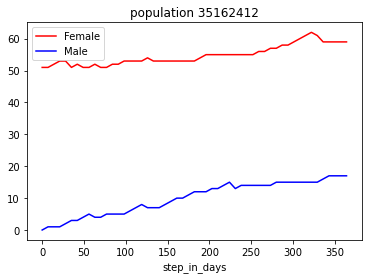

In [43]:
#Sex plots
print("SEX")
for population_id in pd.unique(read_hist['population_id']):
    data = read_hist[read_hist['population_id'] == population_id]
    data = data.assign(step_in_days=data['step'] * delta_t)
    data.set_index('step_in_days', inplace=True)
    data.groupby('run')['Female'].plot(legend=False, color = 'red')
    data.groupby('run')['Male'].plot(legend=False, color = 'blue')
    plt.title('population ' + str(population_id))
    leg = plt.legend(['Female','Male']) #, color = ['red', 'blue', 'green', 'orange', 'black']
    leg.legendHandles[0].set_color('red')
    leg.legendHandles[1].set_color('blue')
    plt.show()
    


BREED


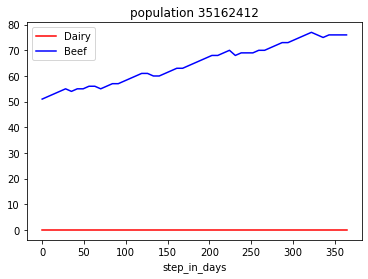

In [44]:
print("BREED")
#Breed plots
for population_id in pd.unique(read_hist['population_id']):
    data = read_hist[read_hist['population_id'] == population_id]
    data = data.assign(step_in_days=data['step'] * delta_t)
    data.set_index('step_in_days', inplace=True)
    data.groupby('run')['Dairy'].plot(legend=False, color = 'red')
    data.groupby('run')['Beef'].plot(legend=False, color = 'blue')
    plt.title('population ' + str(population_id))
    leg = plt.legend(['Dairy','Beef']) #, color = ['red', 'blue', 'green', 'orange', 'black']
    leg.legendHandles[0].set_color('red')
    leg.legendHandles[1].set_color('blue')
    plt.show()   


PARITY


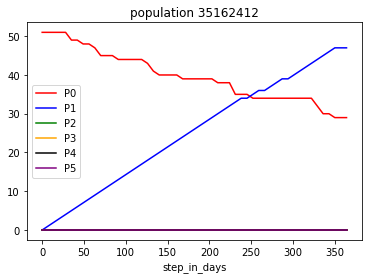

In [45]:
print("PARITY")
#Breed plots
for population_id in pd.unique(read_hist['population_id']):
    step_in_days = read_hist['step'][read_hist['population_id'] == population_id] * delta_t
    data = read_hist[read_hist['population_id'] == population_id]
    data = data.assign(step_in_days=data['step'] * delta_t)
    data.set_index('step_in_days', inplace=True)
    data.groupby('run')['P0'].plot(legend=False, color = 'red')
    data.groupby('run')['P1'].plot(legend=False, color = 'blue')
    data.groupby('run')['P2'].plot(legend=False, color = 'green')
    data.groupby('run')['P3'].plot(legend=False, color = 'orange')
    data.groupby('run')['P4'].plot(legend=False, color = 'black')
    data.groupby('run')['P5'].plot(legend=False, color = 'purple')
    plt.title('population ' + str(population_id))
    leg = plt.legend(['P0','P1','P2', 'P3', 'P4', 'P5']) #, color = ['red', 'blue', 'green', 'orange', 'black']
    leg.legendHandles[0].set_color('red')
    leg.legendHandles[1].set_color('blue')
    leg.legendHandles[2].set_color('green')
    leg.legendHandles[3].set_color('orange')
    leg.legendHandles[4].set_color('black')
    leg.legendHandles[5].set_color('purple')
    plt.show()
    


LIFE-CYCLE


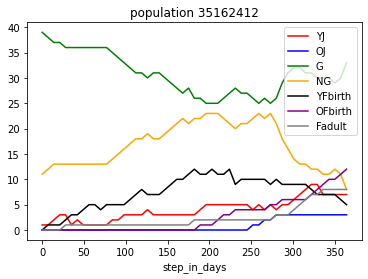

In [46]:
print("LIFE-CYCLE")
#Breed plots
for population_id in pd.unique(read_hist['population_id']):
    step_in_days = read_hist['step'][read_hist['population_id'] == population_id] * delta_t
    data = read_hist[read_hist['population_id'] == population_id]
    data = data.assign(step_in_days=data['step'] * delta_t)
    data.set_index('step_in_days', inplace=True)
    data.groupby('run')['YJ'].plot(legend=False, color = 'red')
    data.groupby('run')['OJ'].plot(legend=False, color = 'blue')
    data.groupby('run')['G'].plot(legend=False, color = 'green')
    data.groupby('run')['NG'].plot(legend=False, color = 'orange')
    data.groupby('run')['YFbirth'].plot(legend=False, color = 'black')
    data.groupby('run')['OFbirth'].plot(legend=False, color = 'purple')
    data.groupby('run')['Fadult'].plot(legend=False, color = 'gray')
    plt.title('population ' + str(population_id))
    leg = plt.legend(['YJ','OJ','G', 'NG', 'YFbirth', 'OFbirth', 'Fadult']) #, color = ['red', 'blue', 'green', 'orange', 'black']
    leg.legendHandles[0].set_color('red')
    leg.legendHandles[1].set_color('blue')
    leg.legendHandles[2].set_color('green')
    leg.legendHandles[3].set_color('orange')
    leg.legendHandles[4].set_color('black')
    leg.legendHandles[5].set_color('purple')
    leg.legendHandles[6].set_color('gray')
    plt.show()   


HEALTH-STATE


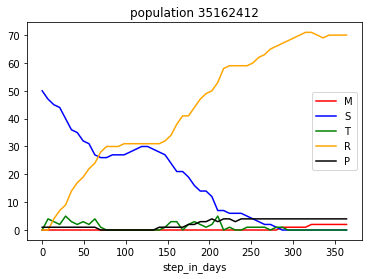

In [47]:
print("HEALTH-STATE")
#Breed plots
for population_id in pd.unique(read_hist['population_id']):
    step_in_days = read_hist['step'][read_hist['population_id'] == population_id] * delta_t
    data = data.assign(step_in_days=data['step'] * delta_t)
    data['step_in_days'] = data['step'] * delta_t
    data.set_index('step_in_days', inplace=True)
    data.groupby('run')['M'].plot(legend=False, color = 'red')
    data.groupby('run')['S'].plot(legend=False, color = 'blue')
    data.groupby('run')['T'].plot(legend=False, color = 'green')
    data.groupby('run')['R'].plot(legend=False, color = 'orange')
    data.groupby('run')['P'].plot(legend=False, color = 'black')
    plt.title('population ' + str(population_id))
    leg = plt.legend(['M','S','T', 'R', 'P']) #, color = ['red', 'blue', 'green', 'orange', 'black']
    leg.legendHandles[0].set_color('red')
    leg.legendHandles[1].set_color('blue')
    leg.legendHandles[2].set_color('green')
    leg.legendHandles[3].set_color('orange')
    leg.legendHandles[4].set_color('black')
    plt.show()   